## 1.0 Install and Imports

In [2]:
# !pip install -U sentence-transformers
# !pip install transformers
# !pip install tqdm
# !pip install langdetect
# !pip install nltk
# !pip install gensim
# !pip install tensorflow
# !pip install jieba konlpy
# !pip install indic-nlp-library
# !pip install camel-tools
# !pip install imbalanced-learn
# !pip install scikit-learn


In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import string
import re
from tqdm import tqdm
import jieba
import nltk
from nltk.corpus import stopwords
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from camel_tools.tokenizers.word import simple_word_tokenize

from datasets import Dataset
from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForSequenceClassification,
    Trainer
)

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score

### 1.1 Prepare GPU for machine learning

In [2]:
# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU is: NVIDIA GeForce RTX 3060 Laptop GPU


## 2.0 Load Dataset and EDA

In [3]:
balanced_df = pd.read_csv("balanced_dataset.csv")
balanced_df

,text,label
0,#Quran\n #Qurantime \n#QuranHour #quran_thediv...,eng_religion
1,t'as pas honte d'opprimer les gens comme ça es...,fre_bully
2,सबरीमाला में महिलाओं के प्रवेश पर सुप्रीम कोर्...,hin_fake
3,@Main_Amitabh @SanjayAzadSln @ArvindKejriwal य...,hin_offense
4,@USER Ne yani kendini affetir macimi bu ? 4 ki...,tur_nonbully
...,...,...
35931,最折磨的就是用美化的“爱”说服自己还能活着还能让日子过得没那么绝望，到后来有一天会发现自己的...,chi_nonbully
35932,@narendramodi @netanyahu सीरिया पाकिस्तान से भ...,hin_fake
35933,"আল্লাহ তাকে হেদায়াত করো, হেদায়াতের মালিক তো তু...",ben_sexual
35934,you can literally do almost anything to anyone...,eng_neutral


In [4]:
balanced_df.isna().sum()

text     0
label    0
dtype: int64

In [5]:
# Full EDA function
def eda_report(df, title_prefix=""):
    import warnings
    warnings.filterwarnings('ignore')
    print(f"\n--- {title_prefix} Dataset Summary ---")
    print(df.info())
    print("\nSample Data:\n", df.sample(5))
    print("\nLabel Distribution:\n", df['label'].value_counts())

    # Plot 1: Label distribution
    plt.figure(figsize=(14, 6))
    sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
    plt.title(f'{title_prefix} Dataset - Label Distribution')
    plt.tight_layout()
    plt.show()

    # Plot 2: Text length distribution
    df['text_length'] = df['text'].astype(str).apply(len)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['text_length'], bins=50, kde=True, color='teal')
    plt.title(f'{title_prefix} Dataset - Text Length Distribution')
    plt.xlabel("Text Length (characters)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot 4: Average text length per label
    avg_lengths = df.groupby('label')['text_length'].mean().sort_values(ascending=False)
    plt.figure(figsize=(14, 6))
    sns.barplot(x=avg_lengths.values, y=avg_lengths.index, palette="viridis")
    plt.title(f'{title_prefix} Dataset - Avg Text Length per Label')
    plt.xlabel("Average Length")
    plt.ylabel("Label")
    plt.tight_layout()
    plt.show()

    # Plot 5: Language-wise label count (based on label prefix)
    df['lang'] = df['label'].apply(lambda x: x[:3])
    lang_counts = df['lang'].value_counts()
    plt.figure(figsize=(10, 4))
    sns.barplot(x=lang_counts.index, y=lang_counts.values, palette='coolwarm')
    plt.title(f'{title_prefix} Dataset - Language-wise Distribution')
    plt.xlabel("Language Code")
    plt.ylabel("Sample Count")
    plt.tight_layout()
    plt.show()



--- Balanced Dataset Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35936 entries, 0 to 35935
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    35936 non-null  object
 1   label   35936 non-null  object
dtypes: object(2)
memory usage: 561.6+ KB
None

Sample Data:
                                                     text         label
3757                       @user c'était ironique mongol     fre_bully
24320           成年人改名改姓哪里那么容易。。。活在真空世界呢？而且为什么跟母性会被bully？  chi_nonbully
20523                                       Purtroppo si  ita_nonbully
15627  @XJohansonnn Ahhhh, I was about to say! If tha...   eng_neutral
9090               মরে দেখ মাগি বুঝবি পরকাল কাকে বলে????    ben_sexual

Label Distribution:
 label
eng_religion     1288
eng_race         1280
eng_sex          1280
eng_neutral      1152
tur_bully        1071
por_bully        1048
rus_bully        1039
chi_bully        1039
spa_bully        1038


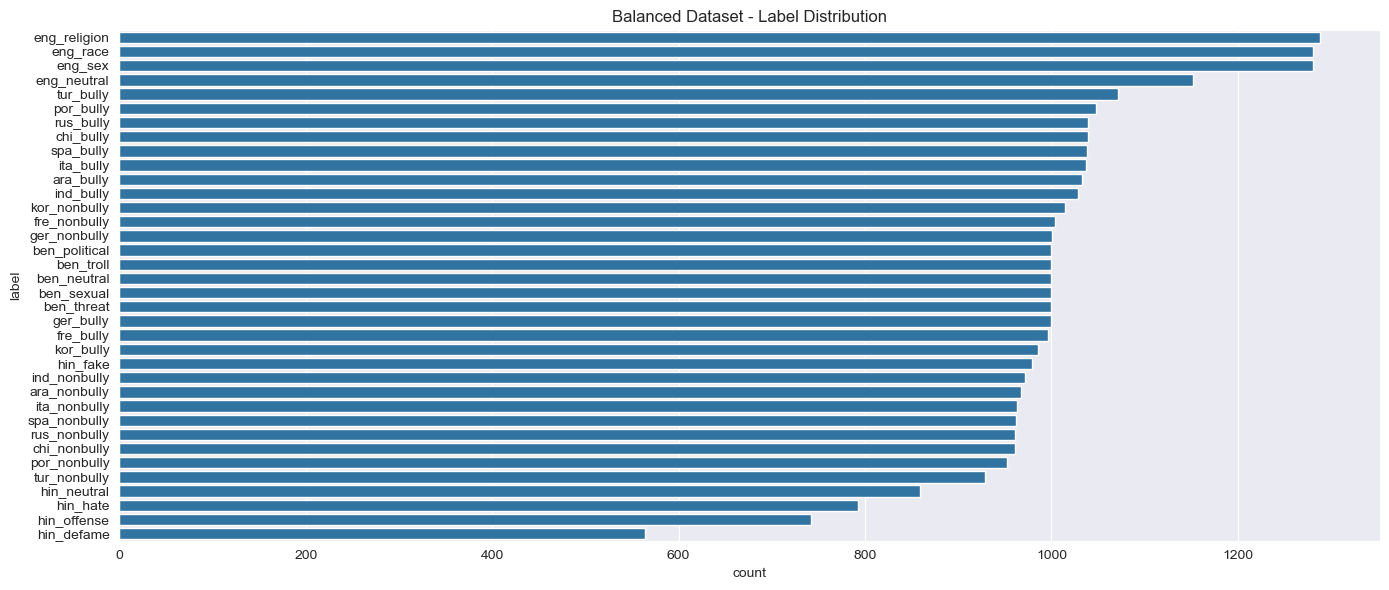

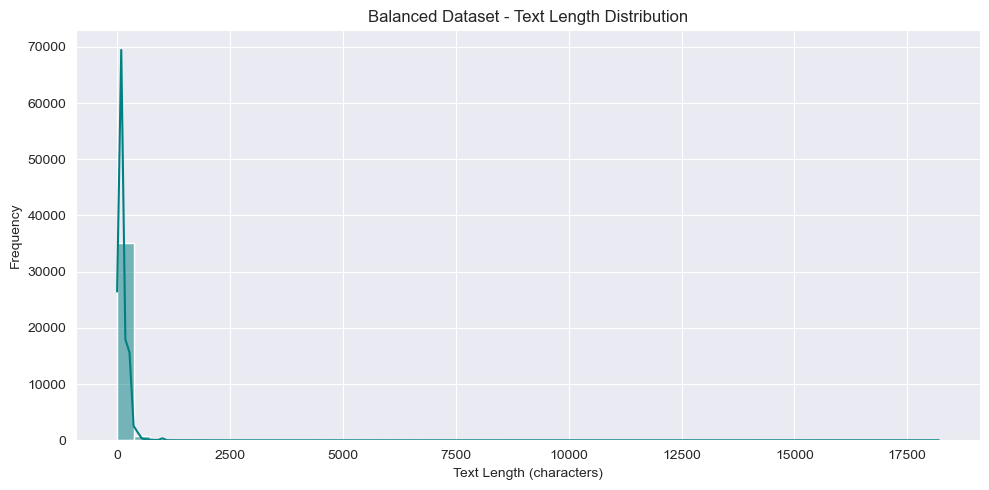

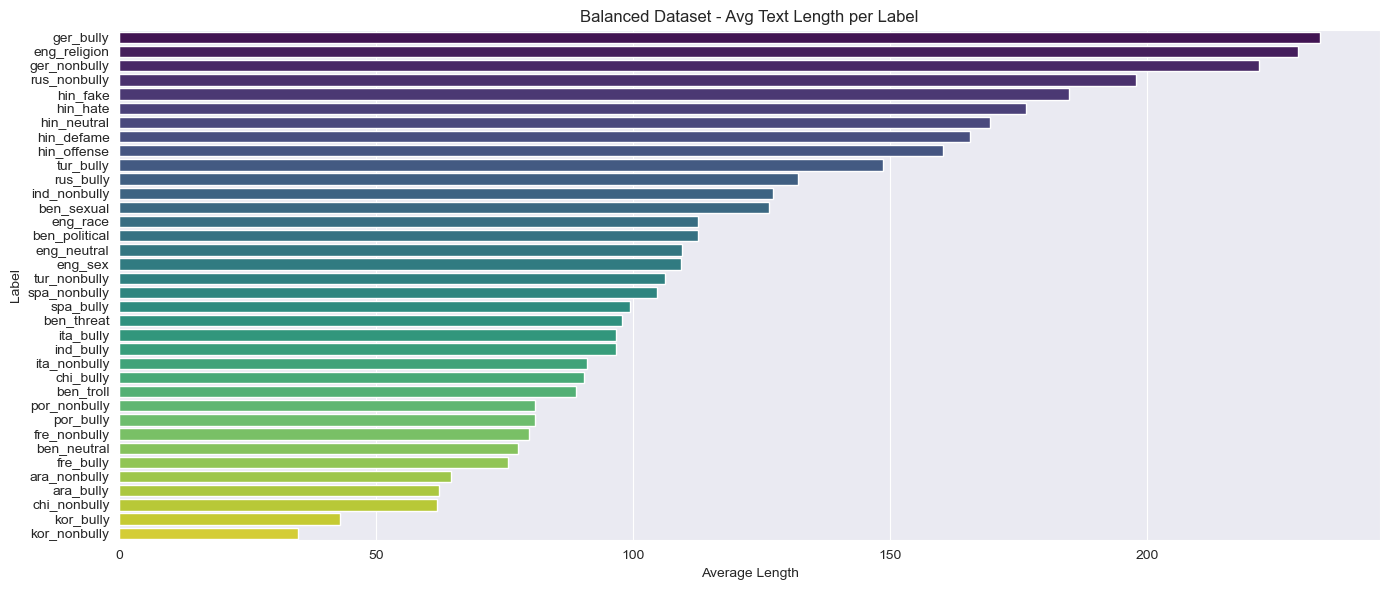

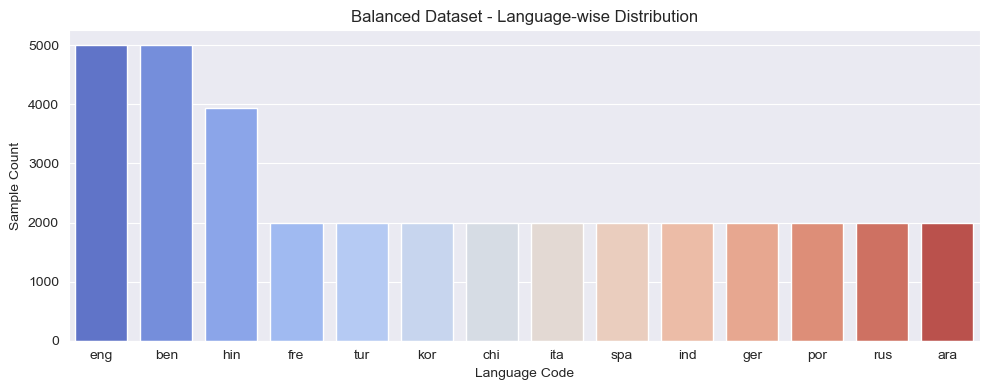

In [6]:
eda_report(balanced_df, "Balanced")

In [7]:
print(balanced_df['lang'].unique())

['eng' 'fre' 'hin' 'tur' 'ben' 'kor' 'chi' 'ita' 'spa' 'ind' 'ger' 'por'
 'rus' 'ara']


## 3.0 Preprocessing

### 3.1 Text Cleaning

In [8]:
# ===== Preprocessing =====
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() #   All in lower case
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove Hyperlinks
    text = re.sub(r"@\w+", "", text)  # remove @mention
    text = re.sub(r"#", "", text)  # remove hashtag
    text = text.replace("“", "").replace("”", "")  # remove chinese quotes
    text = re.sub(r"[^\w\s\u4e00-\u9fff]", "", text)  # Remove Chinese punctuation
    text = re.sub(r"\d+", "", text)  # remove numbers
    text = re.sub(r"\s+", " ", text).strip() # remove whitespaces
    return text

In [9]:
cleaned_df = pd.DataFrame({
    'text': balanced_df['text'].apply(preprocess_text),
    'label': balanced_df['label'],
    'lang': balanced_df['lang']
})

cleaned_df.head()

,text,label,lang
0,quran qurantime quranhour quran_thedivinebook ...,eng_religion,eng
1,tas pas honte dopprimer les gens comme ça espè...,fre_bully,fre
2,सबरमल म महलओ क परवश पर सपरम करट क आदश क तलन कर...,hin_fake,hin
3,य दलल जलन वल आतकवद ह इसक त पगल कतत क तरह दड दड...,hin_offense,hin
4,ne yani kendini affetir macimi bu kisi fazla v...,tur_nonbully,tur


### 3.1.1 Testing langdetect

In [10]:
langdetect_to_tokenizer = {
    'en': 'eng',
    'hi': 'hin',
    'bn': 'ben',
    'ar': 'ara',
    'de': 'ger',
    'ru': 'rus',
    'fr': 'fre',
    'it': 'ita',
    'es': 'spa',
    'ko': 'kor',
    'tr': 'tur',
    'zh': 'chi',
    'zh-cn': 'chi',
    'yue': 'chi',
    'pt': 'por',
    'id': 'ind'
}

In [11]:
from langdetect import detect
print(detect("Geeksforgeeks is a computer science portal for geeks"))

en


In [12]:
cleaned_df['langdetect'] = cleaned_df['text'].apply(lambda x: detect(x) if isinstance(x, str) and x.strip() else 'ar') #default tokenizer is ara/ar with simple tokenizer

In [14]:
# Create a new column with the tokenizer code
cleaned_df['tokenizer_code'] = cleaned_df['langdetect'].map(langdetect_to_tokenizer).fillna('ara')
cleaned_df[['text', 'lang','tokenizer_code']].head()

,text,lang,tokenizer_code
0,quran qurantime quranhour quran_thedivinebook ...,eng,eng
1,tas pas honte dopprimer les gens comme ça espè...,fre,fre
2,सबरमल म महलओ क परवश पर सपरम करट क आदश क तलन कर...,hin,hin
3,य दलल जलन वल आतकवद ह इसक त पगल कतत क तरह दड दड...,hin,hin
4,ne yani kendini affetir macimi bu kisi fazla v...,tur,tur


In [15]:
# Compare langdetect and tokenizer_code columns
cleaned_df['mapping_correct'] = cleaned_df.apply(
    lambda row: row['tokenizer_code'] == langdetect_to_tokenizer.get(row['langdetect'], 'unknown'),
    axis=1
)

# Summary statistics
accuracy = cleaned_df['mapping_correct'].mean()
total = len(balanced_df)
correct = cleaned_df['mapping_correct'].sum()
incorrect = total - correct

print(f"✅ Mapping Accuracy: {accuracy:.2%} ({correct}/{total} correct)")

✅ Mapping Accuracy: 97.10% (34893/35936 correct)


**An accuracy above 80% is good and deemed suitable for detecting the tokeniser suitable**

In [16]:
# Show mismatches
mismatches = cleaned_df[~cleaned_df['mapping_correct']]
print(mismatches[['langdetect', 'tokenizer_code']].value_counts())

langdetect  tokenizer_code
tl          ara               136
no          ara                94
ca          ara                91
so          ara                87
af          ara                75
et          ara                67
cy          ara                58
sv          ara                34
ro          ara                32
nl          ara                31
uk          ara                30
da          ara                29
bg          ara                29
sl          ara                28
fi          ara                27
fa          ara                25
mk          ara                24
ne          ara                24
mr          ara                23
sw          ara                21
hr          ara                17
lt          ara                12
pl          ara                 9
sk          ara                 8
lv          ara                 7
hu          ara                 7
ur          ara                 7
sq          ara                 6
vi          ara      

### 3.2 Encoding (optional)

In [10]:
le = LabelEncoder()
cleaned_df["label_encoded"] = le.fit_transform(cleaned_df["label"])

# View mapping of the label encoder
le_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_map)

cleaned_df

{'ara_bully': 0, 'ara_nonbully': 1, 'ben_neutral': 2, 'ben_political': 3, 'ben_sexual': 4, 'ben_threat': 5, 'ben_troll': 6, 'chi_bully': 7, 'chi_nonbully': 8, 'eng_neutral': 9, 'eng_race': 10, 'eng_religion': 11, 'eng_sex': 12, 'fre_bully': 13, 'fre_nonbully': 14, 'ger_bully': 15, 'ger_nonbully': 16, 'hin_defame': 17, 'hin_fake': 18, 'hin_hate': 19, 'hin_neutral': 20, 'hin_offense': 21, 'ind_bully': 22, 'ind_nonbully': 23, 'ita_bully': 24, 'ita_nonbully': 25, 'kor_bully': 26, 'kor_nonbully': 27, 'por_bully': 28, 'por_nonbully': 29, 'rus_bully': 30, 'rus_nonbully': 31, 'spa_bully': 32, 'spa_nonbully': 33, 'tur_bully': 34, 'tur_nonbully': 35}


,text,label,lang,label_encoded
0,quran qurantime quranhour quran_thedivinebook ...,eng_religion,eng,11
1,tas pas honte dopprimer les gens comme ça espè...,fre_bully,fre,13
2,सबरमल म महलओ क परवश पर सपरम करट क आदश क तलन कर...,hin_fake,hin,18
3,य दलल जलन वल आतकवद ह इसक त पगल कतत क तरह दड दड...,hin_offense,hin,21
4,ne yani kendini affetir macimi bu kisi fazla v...,tur_nonbully,tur,35
...,...,...,...,...
35931,最折磨的就是用美化的爱说服自己还能活着还能让日子过得没那么绝望到后来有一天会发现自己的这种美...,chi_nonbully,chi,8
35932,सरय पकसतन स भ बर हलत म भरत,hin_fake,hin,18
35933,আললহ তক হদয়ত কর হদয়তর মলক ত তম,ben_sexual,ben,4
35934,you can literally do almost anything to anyone...,eng_neutral,eng,9


In [10]:
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

### 3.3 Tokenisation

### 3.3.1 Tokenisation for Rule Based Algorithm

In [11]:
# 📦 Download required NLTK resources
# 'punkt' is used for tokenizing sentences
# 'stopwords' provides lists of common stopwords for various languages
nltk.download('punkt')  # corrected from 'punkt_tab'
nltk.download('stopwords')

# Get English stopwords
eng_stop_words = set(stopwords.words('english'))

# 🛑 Define Hindi stopwords manually
# NLTK does not include Hindi stopwords, so we create a custom list 
hindi_stopwords = set([
    "और", "के", "है", "यह", "था", "जो", "पर", "को",
    "में", "से", "भी", "थे", "तक", "लेकिन"
])

# 🛑 Load Bengali stopwords from NLTK
# These are common Bengali words that can be filtered out
bengali_stopwords = set(stopwords.words('bengali'))

# 🔤 Set up Hindi text normalizer
# This helps clean and standardize Hindi text (e.g., removing diacritics)
factory = IndicNormalizerFactory()
normalizer = factory.get_normalizer("hi")

# 🇰🇷 Try to load Korean tokenizer
# Mecab is preferred for performance and accuracy
# If Mecab is unavailable (e.g., on Windows), fall back to Okt
try:
    from konlpy.tag import Mecab
    mecab = Mecab()
except:
    from konlpy.tag import Okt
    mecab = Okt()

# 🐢 Enable progress bars for pandas operations
# Useful when applying functions to large datasets
tqdm.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KTYJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KTYJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# ===== Tokenisation =====
def tokenize_eng(text):
    tokens =  nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in eng_stop_words]
    return filtered_tokens

def tokenize_hin(text):
    # 归一化
    text = normalizer.normalize(text)
    tokens = list(indic_tokenize.trivial_tokenize(text, lang='hi'))
    # 去停用词
    tokens = [t for t in tokens if t not in hindi_stopwords]
    return tokens

def tokenize_ben(text):
    tokens = list(indic_tokenize.trivial_tokenize(text, lang='bn'))
    tokens = [t for t in tokens if t not in bengali_stopwords]
    return tokens

def tokenize_ara(text):
    return simple_word_tokenize(text)

def tokenize_ger(text):
    return nltk.word_tokenize(text, language='german')

def tokenize_rus(text):
    return nltk.word_tokenize(text, language='russian')

def tokenize_fre(text):
    return nltk.word_tokenize(text, language='french')

def tokenize_ita(text):
    return nltk.word_tokenize(text, language='italian')

def tokenize_spa(text):
    return nltk.word_tokenize(text, language='spanish')

def tokenize_kor(text):
    if hasattr(mecab, 'morphs'):
        return mecab.morphs(text)
    else:
        return list(text)

def tokenize_tur(text):
    return nltk.word_tokenize(text, language='turkish')

def tokenize_chi(text):
    return list(jieba.cut(text))

def tokenize_por(text):
    return nltk.word_tokenize(text, language='portuguese')

def tokenize_ind(text):
    return nltk.word_tokenize(text)

# ===== 映射表 =====
tokenizers = {
    'eng': tokenize_eng,  # English
    'hin': tokenize_hin,  # Hindi
    'ben': tokenize_ben,  # Bengali
    'ara': tokenize_ara,  # Arabic
    'ger': tokenize_ger,  # German
    'rus': tokenize_rus,  # Russian
    'fre': tokenize_fre,  # French
    'ita': tokenize_ita,  # Italian
    'spa': tokenize_spa,  # Spanish
    'kor': tokenize_kor,  # Korean
    'tur': tokenize_tur,  # Turkish
    'chi': tokenize_chi,  # Chinese
    'por': tokenize_por,  # Portuguese
    'ind': tokenize_ind   # Indonesian
}


In [13]:
# ===== Tokenize by language =====
def tokenize_by_lang(row):
    lang = row['lang']
    tokenizer = tokenizers.get(lang, lambda t: t.split())
    return tokenizer(row['text'])



In [14]:
cleaned_df['tokens'] = cleaned_df.progress_apply(tokenize_by_lang, axis=1)
cleaned_df[['text', 'label_encoded', 'lang', 'tokens']].head()

  0%|          | 8/35936 [00:03<4:18:53,  2.31it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\KTYJ\AppData\Local\Temp\jieba.cache
Loading model cost 0.834 seconds.
Prefix dict has been built successfully.
100%|██████████| 35936/35936 [00:19<00:00, 1868.25it/s]


,text,label_encoded,lang,tokens
0,quran qurantime quranhour quran_thedivinebook ...,11,eng,"[quran, qurantime, quranhour, quran_thedivineb..."
1,tas pas honte dopprimer les gens comme ça espè...,13,fre,"[tas, pas, honte, dopprimer, les, gens, comme,..."
2,सबरमल म महलओ क परवश पर सपरम करट क आदश क तलन कर...,18,hin,"[सबरमल, म, महलओ, क, परवश, सपरम, करट, क, आदश, क..."
3,य दलल जलन वल आतकवद ह इसक त पगल कतत क तरह दड दड...,21,hin,"[य, दलल, जलन, वल, आतकवद, ह, इसक, त, पगल, कतत, ..."
4,ne yani kendini affetir macimi bu kisi fazla v...,35,tur,"[ne, yani, kendini, affetir, macimi, bu, kisi,..."


Maximum token count:2457
Minimum token count:0


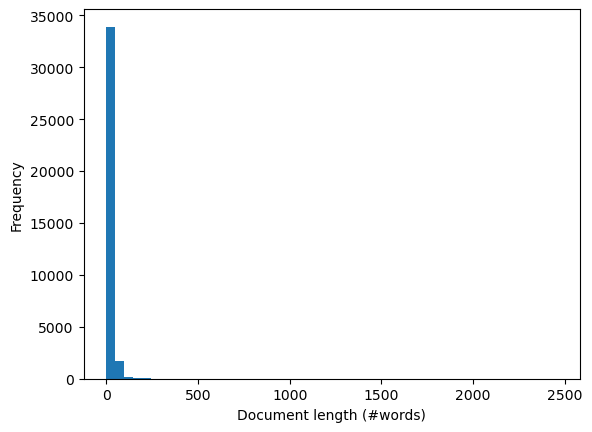

In [16]:
doc_lengths = [len(seq) for seq in cleaned_df['tokens']]

print(f"Maximum token count:{max(doc_lengths)}")
print(f"Minimum token count:{min(doc_lengths)}")
plt.hist(doc_lengths, bins=50)
plt.xlabel("Document length (#words)")
plt.ylabel("Frequency")
plt.show()

In [17]:
longest_idx = cleaned_df['tokens'].apply(len).idxmax()

# Get the number of tokens
longest_length = len(cleaned_df.loc[longest_idx, 'tokens'])

# Get the actual tokens
longest_tokens = cleaned_df.loc[longest_idx, 'tokens']

print(f"Index: {longest_idx}")
print(f"Token count: {longest_length}")
print(f"First 20 Tokens:\n{longest_tokens[:20]}")
cleaned_df.iloc[longest_idx]

Index: 33861
Token count: 2457
First 20 Tokens:
['ben', 'giderim', 'adım', 'kalır', 'dostlar', 'beni', 'hatırlasın', 'büyük', 'şair', 've', 'halk', 'ozanı', 'şıkveyseli', 'doğum', 'yıl', 'dönümünde', 'rahmet', 've', 'saygıyla', 'anıyoruz']


text             ben giderim adım kalır dostlar beni hatırlasın...
label                                                    tur_bully
lang                                                           tur
label_encoded                                                   34
tokens           [ben, giderim, adım, kalır, dostlar, beni, hat...
Name: 33861, dtype: object

90th percentile length: 39.0
95th percentile length: 191.38999999999214


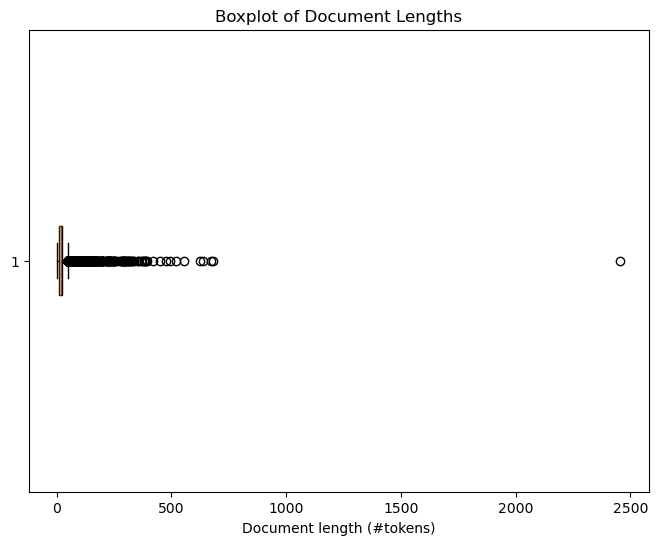

In [18]:
print("90th percentile length:", np.percentile(doc_lengths, 90))
print("95th percentile length:", np.percentile(doc_lengths, 99.8))

plt.figure(figsize=(8, 6))
plt.boxplot(doc_lengths, vert=False, patch_artist=True, showfliers=True)
plt.xlabel("Document length (#tokens)")
plt.title("Boxplot of Document Lengths")
plt.show()

### 3.3.2 XLM Roberta tokenizer (applied during modelling)

In [28]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-large")

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128  # shorter seq length = faster epochs, can be 256 too
    )

df_dataset = Dataset.from_pandas(
    pd.DataFrame({"text": cleaned_df['text'], 
                  "label": cleaned_df['label_encoded']}
                 )
)


df_dataset = df_dataset.map(tokenize_batch)


Map:   0%|          | 0/35936 [00:00<?, ? examples/s]

In [72]:
tokenizer.save_pretrained('./xlm-roberta-large-model')

('./xlm-roberta-large-model\\tokenizer_config.json',
 './xlm-roberta-large-model\\special_tokens_map.json',
 './xlm-roberta-large-model\\sentencepiece.bpe.model',
 './xlm-roberta-large-model\\added_tokens.json',
 './xlm-roberta-large-model\\tokenizer.json')

In [32]:
#input_ids will be the feature here
df_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 35936
})

### 3.4 Vectorisation

### 3.4.1 TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# def identity_tokenizer(text):
#     return text
# 
# #no need preprocessing since we're done it, just a method to bypass
# def passthrough_preprocessor(x):
#     return x

vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x, #already tokenised so just feed the data
    preprocessor=lambda x: x, #no need preprocessing since we done it
    lowercase=False,      # already lowercased so no need       
    token_pattern=None,             
    min_df=2           #Any token that appears in fewer than 2 documents is ignored.
)

In [16]:
y = cleaned_df['label_encoded'].values
X = vectorizer.fit_transform(cleaned_df['tokens'])

In [17]:
import dill
with open('tfidf.dill', 'wb') as f:
    dill.dump(vectorizer, f)

### 3.4.2 Word2Vec (ignore as results are low)

In [98]:
# from gensim.models import Word2Vec
# import numpy as np
# 
# # Ensure the 'cleaned_text' column exists in the DataFrame
# assert 'cleaned_text' in cleaned_df.columns
# 
# # Step 2: Train a Word2Vec model (you could also use a pre-trained one)
# sentences = cleaned_df['tokens'].tolist()
# w2v_model = Word2Vec(
#     sentences,
#     vector_size=100,     # Dimensionality of word vectors (can be increased for richer representations)
#     window=5,            # Context window size for surrounding words
#     min_count=2,         # Ignore words that appear fewer than 2 times
#     workers=4,           # Number of CPU cores to use for training
#     sg=1                 # Use skip-gram model (better for small datasets and multilingual corpora)
# )
# 
# # Step 3: Define a function to compute the average word vector for a sentence
# def get_sentence_vector(tokens, model, vector_size=100):
#     vecs = []
#     for word in tokens:
#         if word in model.wv:
#             vecs.append(model.wv[word])
#     if vecs:
#         return np.mean(vecs, axis=0)  # Average the word vectors
#     else:
#         return np.zeros(vector_size)  # Return a zero vector if no known words are found
# 
# # Step 4: Convert all tokenized text into sentence vectors
# tqdm.pandas(desc="Vectorizing text with Word2Vec")
# cleaned_df['w2vect'] = cleaned_df['tokens'].progress_apply(lambda x: get_sentence_vector(x, w2v_model))
# 
# # Step 5: Create feature matrix X and label vector y
# X = np.vstack(cleaned_df['vector'].values)   # Shape: (number of samples, 100)
# y = cleaned_df['label_encoded'].values               # Make sure the 'label' column exists
# 
# # Optional: Print shapes to verify dimensions
# print("X shape:", X.shape)
# print("y shape:", y.shape)
# 
# y

### 3.5 Oversampling (skipped for xlm-roBERTa as it requires raw text string)


Transformer models expect the inputs as text, so unable to oversample for xlm-roBERTa 

In [ ]:
# X = np.array(df_dataset['input_ids'])
# y = np.array(df_dataset['label'])

<Figure size 1400x600 with 0 Axes>

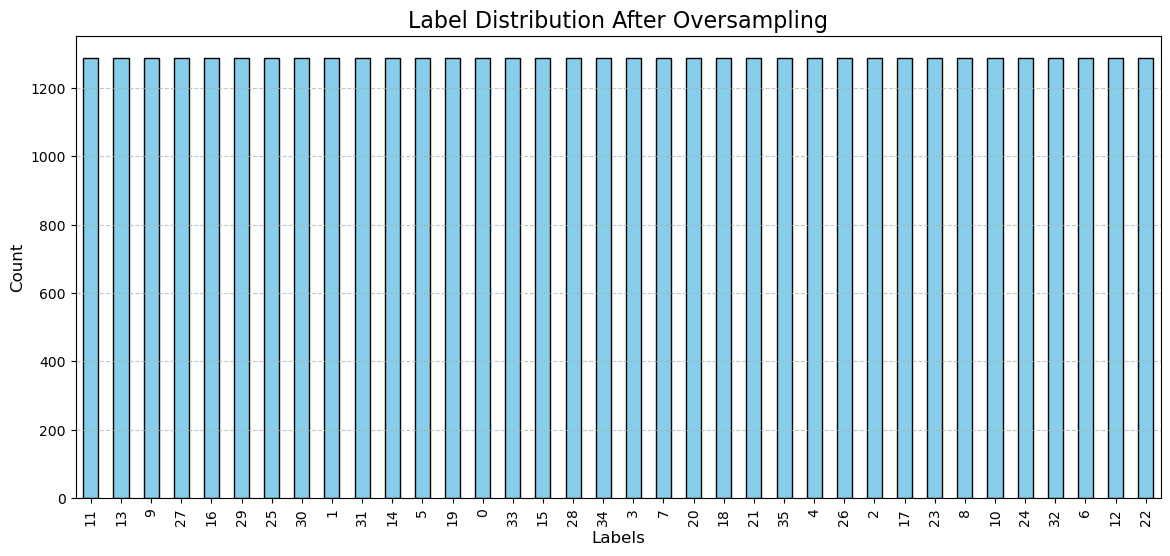

In [32]:
# Perform oversampling
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Count label distribution
label_counts = Counter(y_resampled)

# Convert to DataFrame for plotting
df_counts = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
df_counts = df_counts.sort_values(by='Count', ascending=False)

# Plot bar chart
plt.figure(figsize=(14, 6))
df_counts.plot(kind='bar', legend=False, figsize=(14, 6), color='skyblue', edgecolor='black')

plt.title("Label Distribution After Oversampling", fontsize=16)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Now all the labels are equally balanced, now let's proceed to modelling 

In [33]:
print(len(y_resampled))
X_resampled

46368


<46368x47053 sparse matrix of type '<class 'numpy.float64'>'
	with 688709 stored elements in Compressed Sparse Row format>

## 4.0 Modelling
### 4.1 xlm-RoBERTa

In [49]:
# Use 80% for training and 20% for validation
# No oversampling 
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df["text"].tolist(), cleaned_df["label_encoded"].tolist(),
    test_size=0.2, random_state=42, stratify=cleaned_df["label_encoded"].tolist()
)

In [51]:
train_dataset = Dataset.from_pandas(pd.DataFrame({"text": X_train, "label": y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({"text": X_test, "label": y_test}))

#Map the tokeniser
train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)

train_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/28748 [00:00<?, ? examples/s]

Map:   0%|          | 0/7188 [00:00<?, ? examples/s]

In [52]:
len(le.classes_)

36

In [53]:
#Load model
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-large",
    num_labels=len(le.classes_) #This should be 36 for 36 diff. labels
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
from transformers import TrainingArguments          

training_args = TrainingArguments(
    output_dir="./xlm-roberta-results",
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,   # adjust based on GPU
    per_device_eval_batch_size=8,
    num_train_epochs=5,              
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=2,
    report_to="none"
)

In [55]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_macro = f1.compute(predictions=predictions, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "f1_macro": f1_macro["f1"]}

In [56]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [57]:
# tell pytorch to run this model on GPU
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

In [59]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.826000,0.772912,0.641208,0.585603
2,0.682300,0.671998,0.717446,0.679058
3,0.560900,0.626688,0.743322,0.716232
4,0.461400,0.712115,0.751948,0.728325
5,0.429700,0.845194,0.755982,0.731899


TrainOutput(global_step=17970, training_loss=0.6367289887047769, metrics={'train_runtime': 21170.6123, 'train_samples_per_second': 6.79, 'train_steps_per_second': 0.849, 'total_flos': 3.349280071354368e+16, 'train_loss': 0.6367289887047769, 'epoch': 5.0})

In [60]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.8451935052871704, 'eval_accuracy': 0.7559821925431275, 'eval_f1_macro': 0.731898952682242, 'eval_runtime': 113.0667, 'eval_samples_per_second': 63.573, 'eval_steps_per_second': 7.951, 'epoch': 5.0}


In [78]:
prediction = trainer.predict(test_dataset)
pred_labels = np.argmax(prediction.predictions, axis=-1)
# Convert back to original labels
pred_labels_decoded = le.inverse_transform(pred_labels)
pred_labels_decoded

array(['chi_nonbully', 'chi_nonbully', 'tur_nonbully', ..., 'eng_neutral',
       'spa_bully', 'fre_bully'], dtype=object)

In [69]:
y_test_decoded = le.inverse_transform(y_test)
y_test_decoded

array(['chi_bully', 'chi_nonbully', 'tur_bully', ..., 'eng_religion',
       'spa_bully', 'fre_bully'], dtype=object)

In [71]:
print(classification_report(y_test_decoded, pred_labels_decoded))

               precision    recall  f1-score   support

    ara_bully       0.84      0.83      0.83       207
 ara_nonbully       0.82      0.83      0.82       193
  ben_neutral       0.72      0.66      0.69       200
ben_political       0.78      0.83      0.81       200
   ben_sexual       0.66      0.58      0.62       200
   ben_threat       0.81      0.78      0.80       200
    ben_troll       0.46      0.55      0.50       200
    chi_bully       0.79      0.85      0.82       208
 chi_nonbully       0.82      0.76      0.79       192
  eng_neutral       0.95      0.94      0.95       231
     eng_race       0.99      1.00      0.99       256
 eng_religion       0.98      0.93      0.95       258
      eng_sex       0.98      0.99      0.99       256
    fre_bully       0.81      0.79      0.80       199
 fre_nonbully       0.71      0.74      0.72       201
    ger_bully       0.70      0.66      0.68       200
 ger_nonbully       0.68      0.71      0.70       200
   hin_de

In [83]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_decoded,pred_labels_decoded)
print(cf_matrix)

[[171  36   0 ...   0   0   0]
 [ 33 160   0 ...   0   0   0]
 [  0   0 132 ...   0   0   0]
 ...
 [  0   0   0 ... 130   0   0]
 [  0   0   0 ...   0 165  49]
 [  0   0   0 ...   0  49 137]]


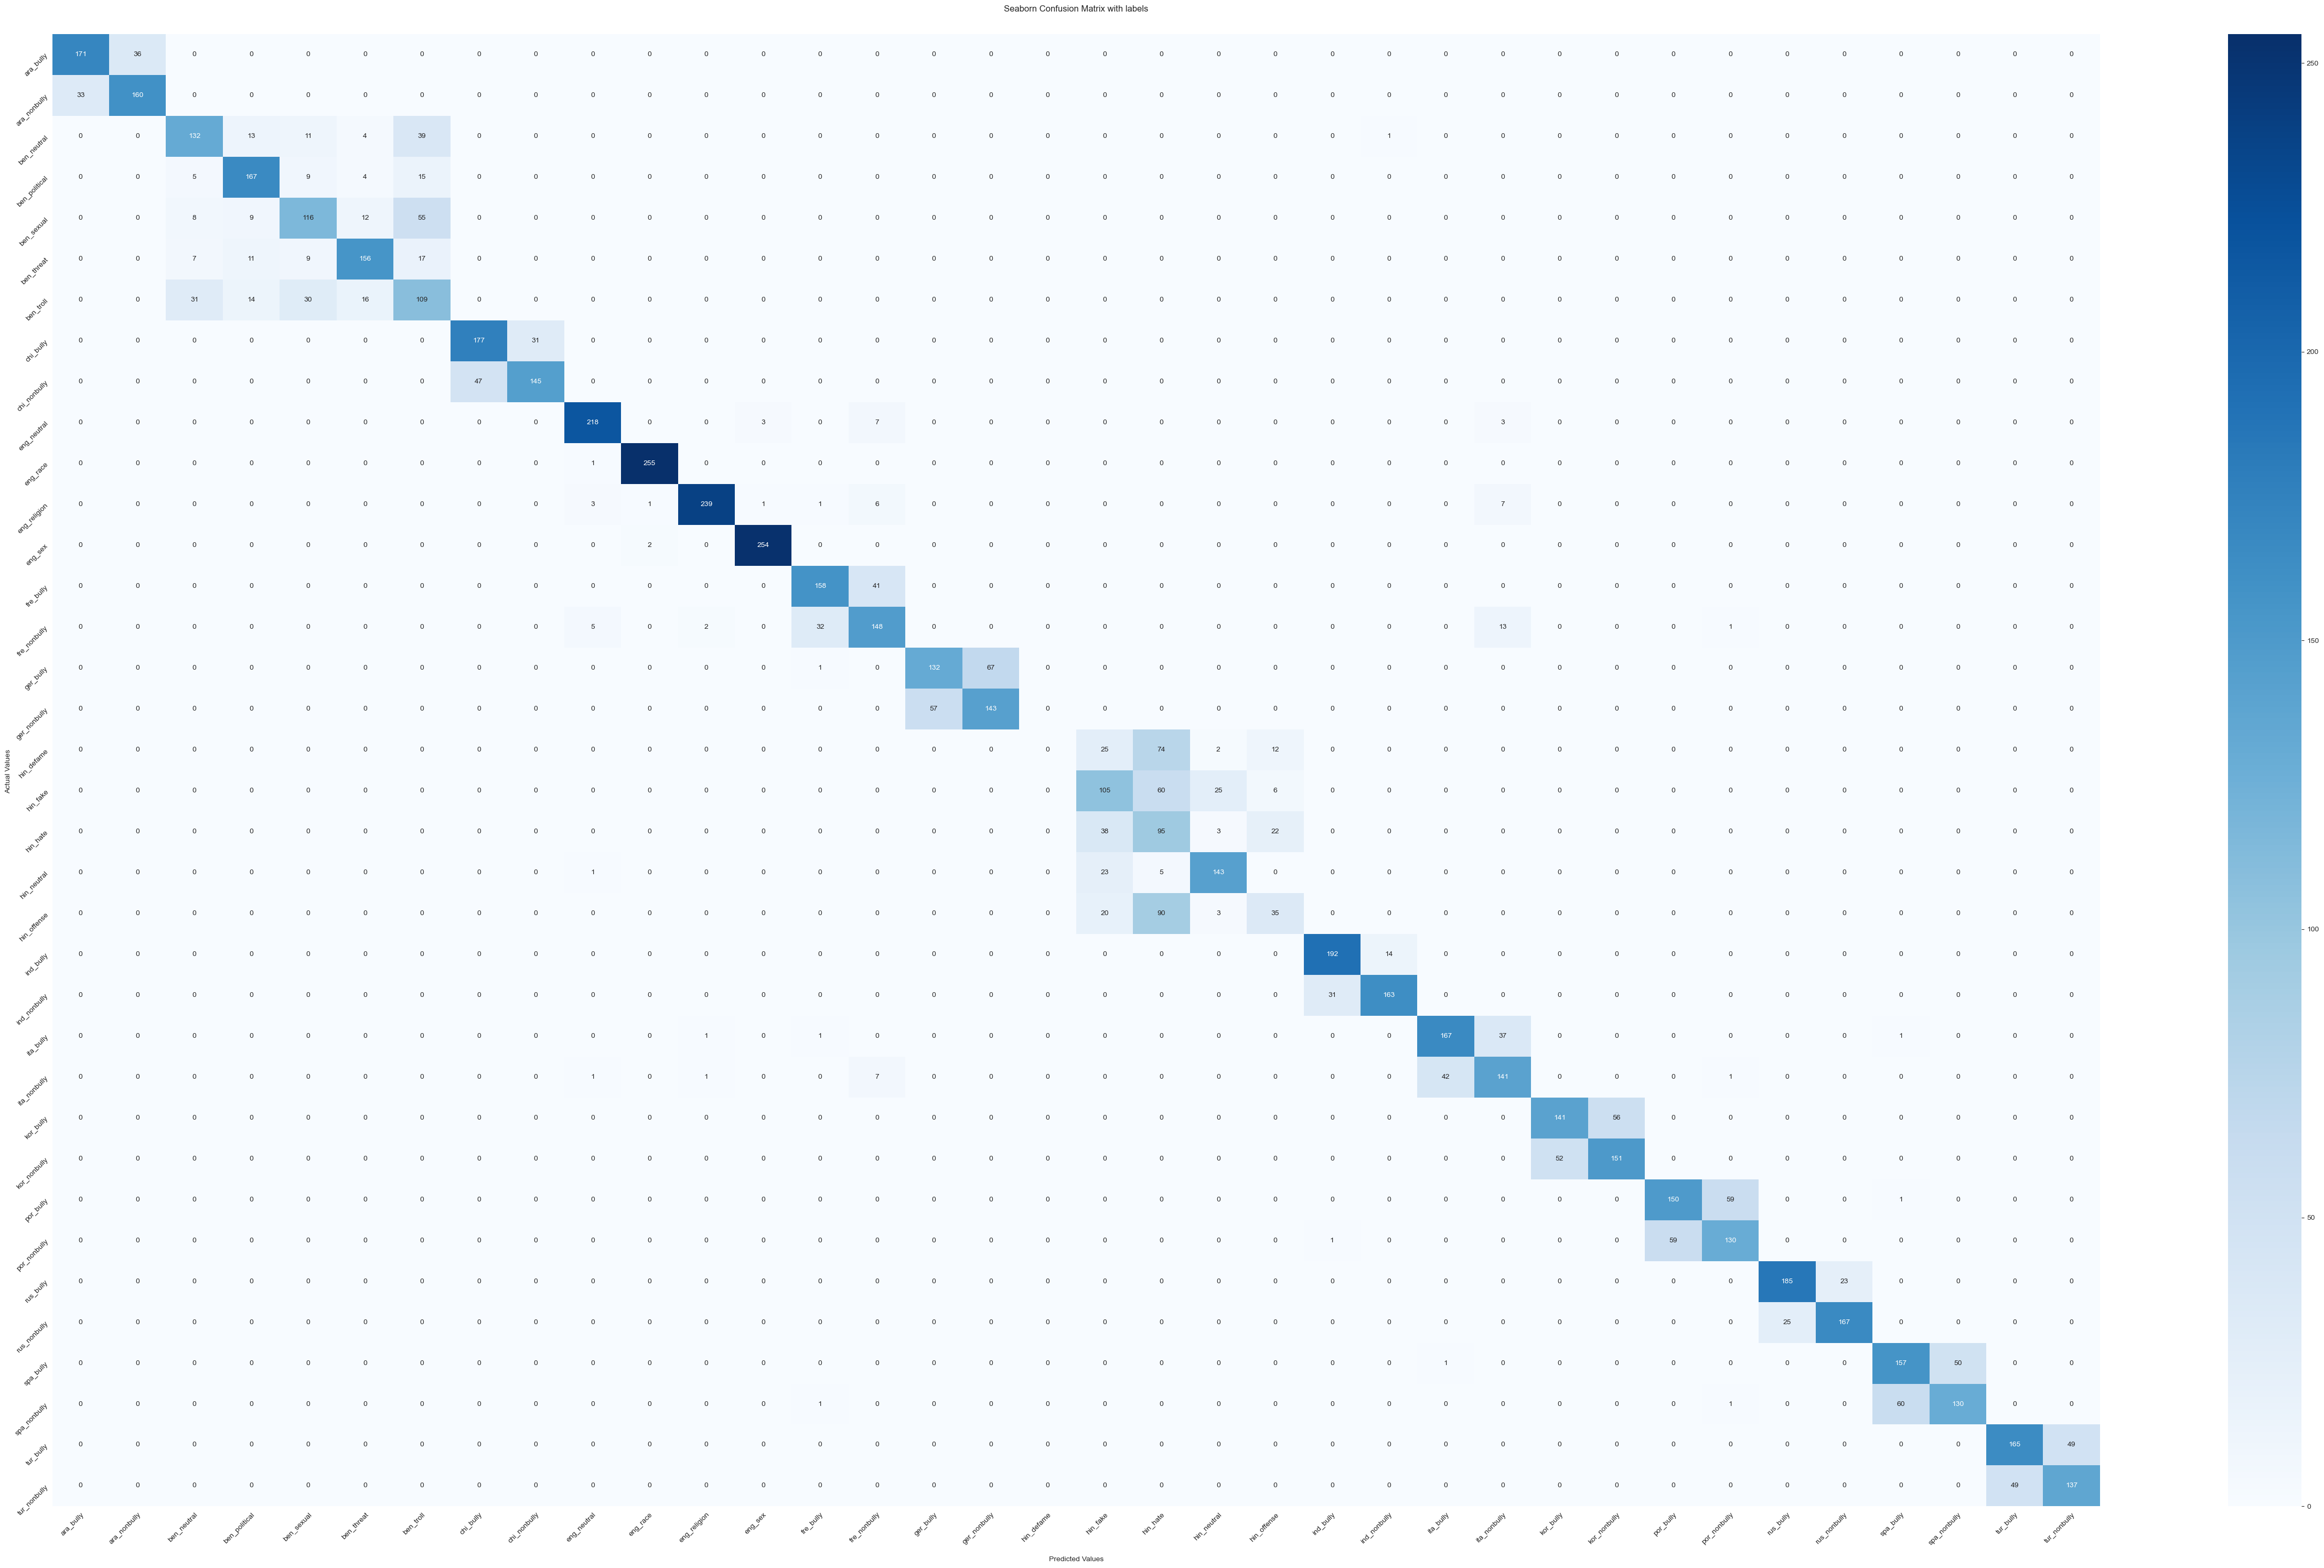

In [92]:
# Add labels, title, and ticks
fig = plt.figure(figsize=(50, 30))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

ax.set_title('XLM-RoBERTa Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout() # Adjust layout to make room for labels
plt.show()

**IMPORTANT! We need to dump Model for future use**

In [ ]:
trainer.save_model("./xlm-roberta-large-model")
# Alternative method to save model
# model.save_pretrained("./xlm-roberta-large-model_2")

### 4.2 Support Vector Machine (SVM) 
Note: Models beyond 4.2 requires training on RESAMPLED DATA

In [34]:
# Reuse this for other algorithms for consistency 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC             
svc = SVC(kernel='rbf', C=1.0)

# Train the model
clf = svc.fit(X_train, y_train)              

# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv
y_pred_svm = svc.predict(X_test)               
print(y_pred_svm)

In [ ]:
y_test_decoded = le.inverse_transform(y_test)
y_pred_svm_decoded = le.inverse_transform(y_pred_svm)


In [56]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score

# REMEMBER THIS WE NEED IT FOR COMPARISON
print(classification_report(y_test_decoded, y_pred_svm_decoded))

svm_acc = accuracy_score(y_test_decoded, y_pred_svm_decoded)
svm_pre = precision_score(y_test_decoded, y_pred_svm_decoded, average='macro')
svm_rec = recall_score(y_test_decoded, y_pred_svm_decoded, average='macro')

print(" Accuracy score for SVM : %.2f%%" % (svm_acc*100))
print("Precision score for SVM : %.2f%%" % (svm_pre*100))
print("   Recall score for SVM : %.2f%%" % (svm_rec*100))


               precision    recall  f1-score   support

    ara_bully       0.90      0.77      0.83       258
 ara_nonbully       0.84      0.86      0.85       262
  ben_neutral       0.72      0.77      0.75       255
ben_political       0.91      0.88      0.89       250
   ben_sexual       0.72      0.74      0.73       237
   ben_threat       0.94      0.82      0.88       270
    ben_troll       0.71      0.68      0.70       263
    chi_bully       0.89      0.78      0.83       288
 chi_nonbully       0.77      0.87      0.82       244
  eng_neutral       0.54      1.00      0.70       237
     eng_race       0.99      0.96      0.97       278
 eng_religion       0.98      0.94      0.96       246
      eng_sex       0.99      0.97      0.98       262
    fre_bully       0.85      0.85      0.85       250
 fre_nonbully       0.81      0.78      0.79       240
    ger_bully       0.76      0.73      0.74       255
 ger_nonbully       0.75      0.74      0.74       254
   hin_de

In [37]:
#Hyperparameter tuning?
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid
# These are the hyperparameters and the values you want to test.
param_grid = {
    'C': [0.1, 10],
    'kernel': ['rbf','linear']
}

# 2. Instantiate GridSearchCV
# The 'cv' parameter specifies the number of folds in cross-validation.
# 'refit=True' makes the grid search refit the best estimator on the whole training set.
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=2)

# 3. Fit the grid search to the data
grid.fit(X_train, y_train)

# 4. View the best parameters
print("Best parameters found: ", grid.best_params_)

# 5. Use the best model for predictions
# The grid object automatically acts as the best-found model
y_pred_grid = grid.predict(X_test)



Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ..................................C=0.1, kernel=rbf; total time= 5.7min
[CV] END ..................................C=0.1, kernel=rbf; total time= 4.4min
[CV] END ...............................C=0.1, kernel=linear; total time= 3.0min
[CV] END ...............................C=0.1, kernel=linear; total time= 3.0min
[CV] END ...................................C=10, kernel=rbf; total time= 3.4min
[CV] END ...................................C=10, kernel=rbf; total time= 3.4min
[CV] END ................................C=10, kernel=linear; total time= 2.0min
[CV] END ................................C=10, kernel=linear; total time= 2.0min
Best parameters found:  {'C': 10, 'kernel': 'rbf'}


NameError: name 'y_test_decoded' is not defined

In [39]:
# Best parameters found:  {'C': 10, 'kernel': 'rbf'}
# You can now evaluate this new model
y_pred_grid_decoded = le.inverse_transform(y_pred_grid)
print(classification_report(y_test_decoded, y_pred_grid_decoded))

               precision    recall  f1-score   support

    ara_bully       0.90      0.78      0.83       258
 ara_nonbully       0.84      0.85      0.85       262
  ben_neutral       0.75      0.77      0.76       255
ben_political       0.90      0.88      0.89       250
   ben_sexual       0.73      0.75      0.74       237
   ben_threat       0.93      0.82      0.87       270
    ben_troll       0.72      0.72      0.72       263
    chi_bully       0.87      0.80      0.83       288
 chi_nonbully       0.79      0.84      0.81       244
  eng_neutral       0.56      1.00      0.72       237
     eng_race       0.99      0.96      0.98       278
 eng_religion       0.99      0.94      0.96       246
      eng_sex       0.99      0.97      0.98       262
    fre_bully       0.86      0.84      0.85       250
 fre_nonbully       0.81      0.80      0.80       240
    ger_bully       0.75      0.72      0.73       255
 ger_nonbully       0.74      0.74      0.74       254
   hin_de

In [40]:
print(" Accuracy score for fine-tuned SVM: %.2f" % accuracy_score(y_test_decoded, y_pred_grid_decoded))
print("Precision score for fine-tuned SVM: %.2f" % precision_score(y_test_decoded, y_pred_grid_decoded,average='macro'))
print("   Recall score for fine-tuned SVM: %.2f" % recall_score(y_test_decoded, y_pred_grid_decoded,average='macro'))


 Accuracy score for fine-tuned SVM: 0.80
Precision score for fine-tuned SVM: 0.80
   Recall score for fine-tuned SVM: 0.80


The fine-tuned SVM model works quite well. We will implement it

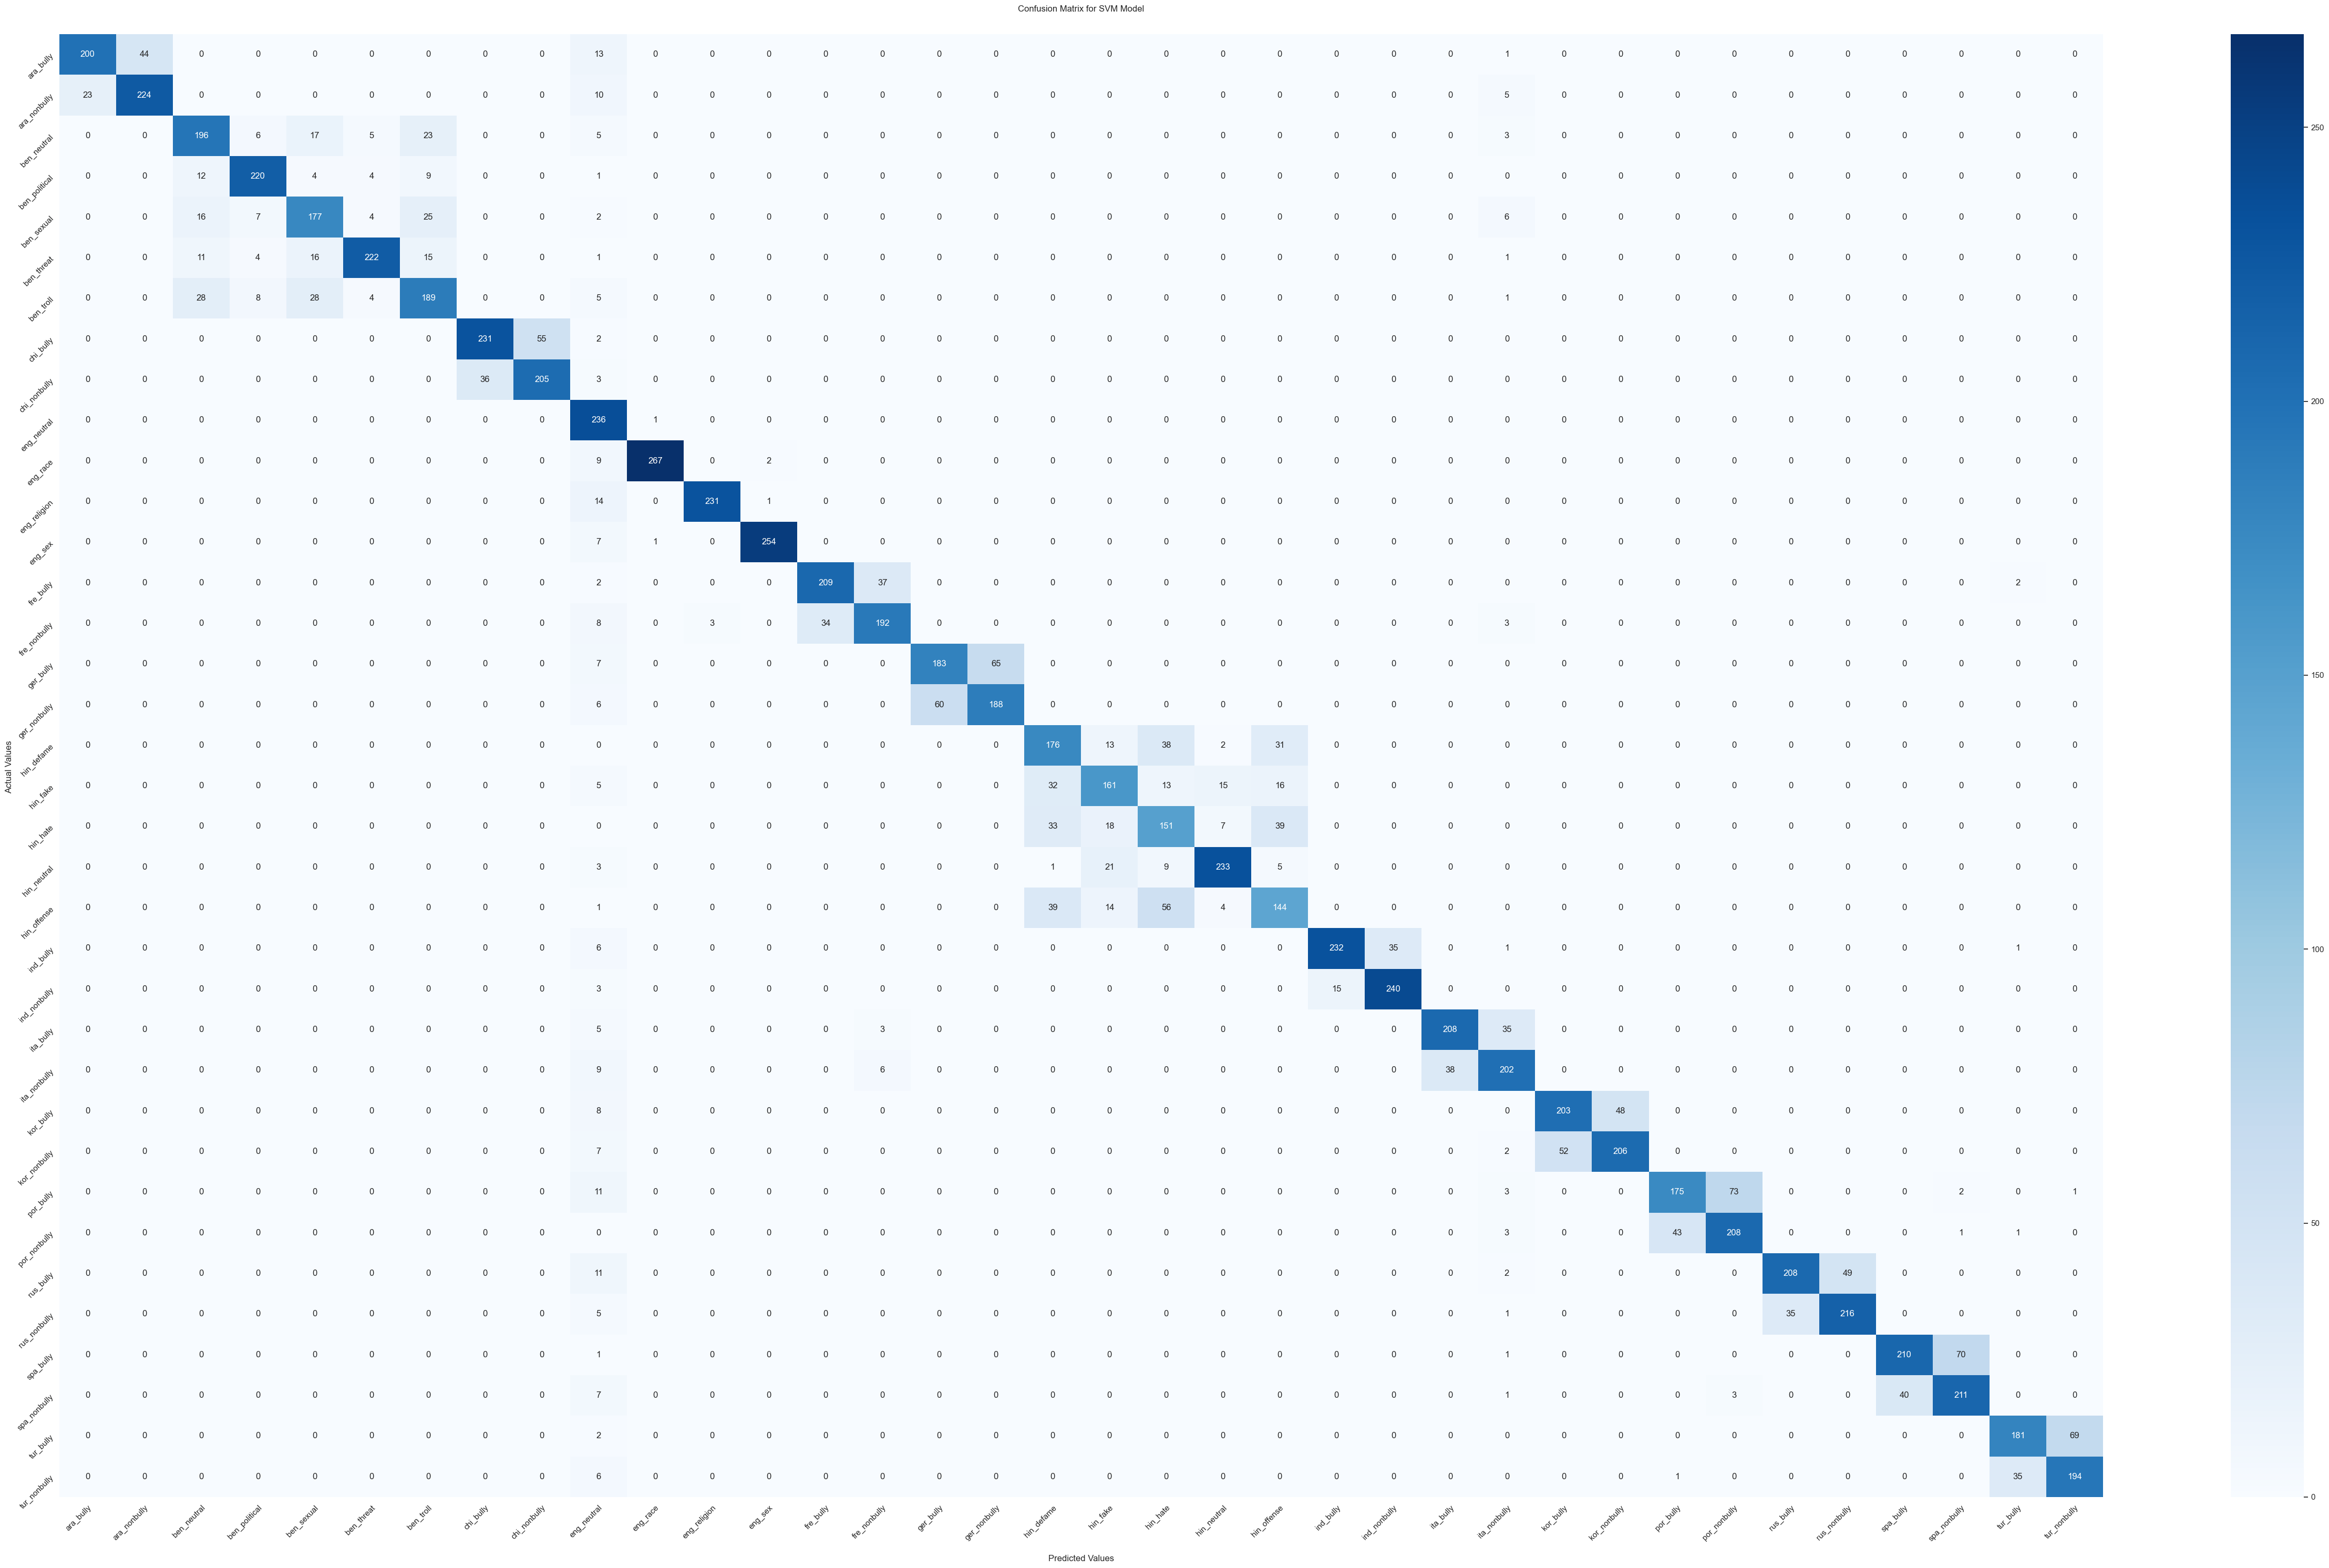

In [42]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_decoded,y_pred_grid_decoded)
#print(cf_matrix)

# Add labels, title, and ticks
fig = plt.figure(figsize=(50, 30))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

ax.set_title('Confusion Matrix for SVM Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout() # Adjust layout to make room for labels
plt.show()

In [44]:
import joblib

# This is the model we want to save

filename = 'svm_finetuned_model.joblib'

# Save the model to the file
joblib.dump(grid, filename)

print(f"Model saved successfully to {filename}")

Model saved successfully to svm_finetuned_model.joblib


### 4.3 Naive Bayes

In [45]:
# Use a Naive Bayes model
# MultinomialNB is designed for frequency-based features 
# exactly what tf-idf or raw counts represent.
from sklearn.naive_bayes import MultinomialNB        #complete this
import numpy as np
nb = MultinomialNB(alpha=1)

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the model
nb.fit(X_train, y_train)                           

y_pred_nb = nb.predict(X_test)                           
print(y_pred_nb)

#y_test_decoded = le.inverse_transform(y_test)
y_pred_nb_decoded = le.inverse_transform(y_pred_nb)

print(classification_report(y_test_decoded, y_pred_nb_decoded))

nb_acc = accuracy_score(y_test_decoded, y_pred_nb_decoded)
nb_pre = precision_score(y_test_decoded, y_pred_nb_decoded, average='macro')
nb_rec = recall_score(y_test_decoded, y_pred_nb_decoded, average='macro')

print(" Accuracy score for NB : %.2f%%" % (nb_acc*100))
print("Precision score for NB : %.2f%%" % (nb_pre*100))
print("   Recall score for NB : %.2f%%" % (nb_rec*100))


[20  8 21 ...  3 14  4]
               precision    recall  f1-score   support

    ara_bully       0.87      0.81      0.84       258
 ara_nonbully       0.82      0.87      0.84       262
  ben_neutral       0.82      0.56      0.67       255
ben_political       0.72      0.92      0.81       250
   ben_sexual       0.53      0.74      0.62       237
   ben_threat       0.80      0.80      0.80       270
    ben_troll       0.74      0.46      0.57       263
    chi_bully       0.74      0.91      0.82       288
 chi_nonbully       0.86      0.63      0.73       244
  eng_neutral       0.92      0.62      0.74       237
     eng_race       0.80      0.92      0.86       278
 eng_religion       0.77      0.99      0.87       246
      eng_sex       0.89      0.81      0.85       262
    fre_bully       0.73      0.93      0.82       250
 fre_nonbully       0.77      0.64      0.70       240
    ger_bully       0.71      0.74      0.72       255
 ger_nonbully       0.73      0.70      

In [46]:
# hyperparameter tuning yoooo
# alpha is the smoothing parameter
#If alpha>0: unseen words still get a small probability, 
# preventing zero-probability issues.

param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)

grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)

y_pred_nb_grid = grid.predict(X_test)
print(y_pred_nb_grid)

y_pred_nb_grid_decoded = le.inverse_transform(y_pred_nb_grid)

nb_acc = accuracy_score(y_test_decoded, y_pred_nb_grid_decoded)
nb_pre = precision_score(y_test_decoded, y_pred_nb_grid_decoded, average='macro')
nb_rec = recall_score(y_test_decoded, y_pred_nb_grid_decoded, average='macro')

print(classification_report(y_test_decoded, y_pred_nb_grid_decoded))
print(" New Accuracy score for NB : %.2f%%" % (nb_acc*100))
print("New Precision score for NB : %.2f%%" % (nb_pre*100))
print("   New Recall score for NB : %.2f%%" % (nb_rec*100))

Best parameters found:  {'alpha': 0.1}
[20  8 21 ...  3 14  4]
               precision    recall  f1-score   support

    ara_bully       0.86      0.84      0.85       258
 ara_nonbully       0.84      0.85      0.85       262
  ben_neutral       0.86      0.63      0.73       255
ben_political       0.77      0.92      0.84       250
   ben_sexual       0.59      0.75      0.66       237
   ben_threat       0.82      0.81      0.81       270
    ben_troll       0.74      0.58      0.65       263
    chi_bully       0.78      0.86      0.82       288
 chi_nonbully       0.82      0.71      0.76       244
  eng_neutral       0.89      0.66      0.76       237
     eng_race       0.75      0.86      0.80       278
 eng_religion       0.76      0.97      0.85       246
      eng_sex       0.84      0.72      0.78       262
    fre_bully       0.77      0.91      0.84       250
 fre_nonbully       0.82      0.71      0.76       240
    ger_bully       0.72      0.73      0.72       255
 

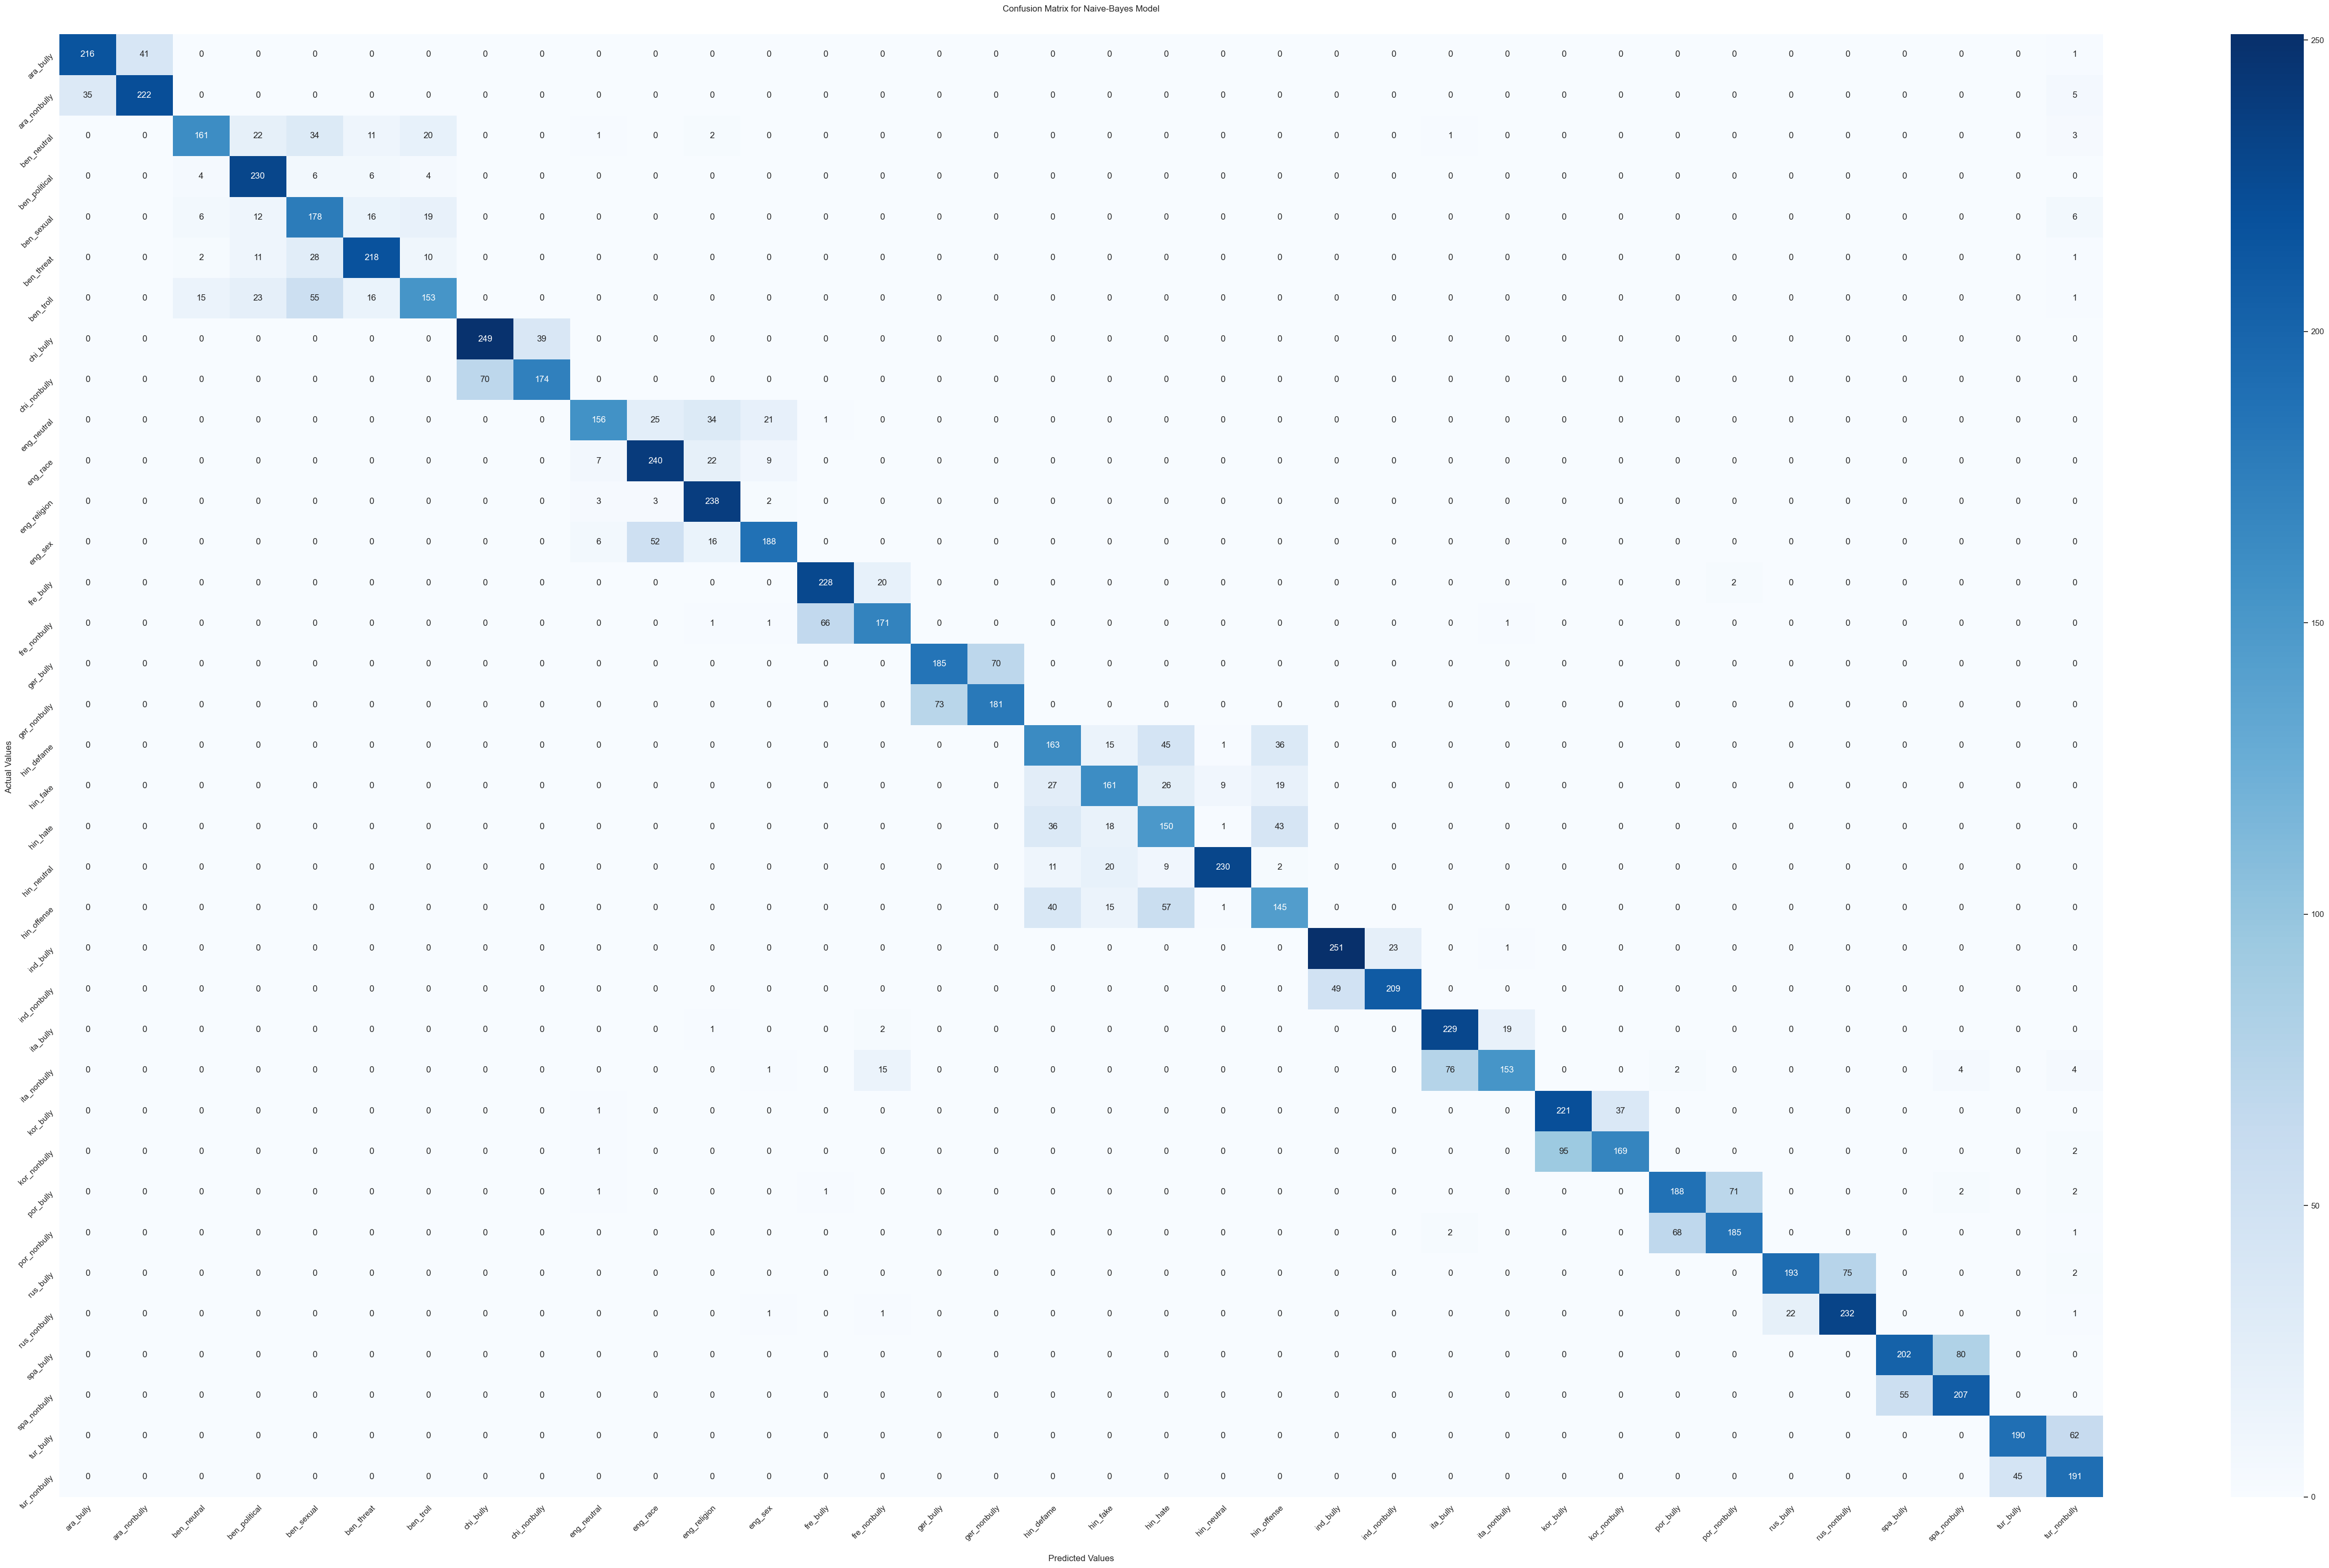

In [47]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_decoded,y_pred_nb_grid_decoded)
#print(cf_matrix)

# Add labels, title, and ticks
fig = plt.figure(figsize=(50, 30))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

ax.set_title('Confusion Matrix for Naive-Bayes Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout() # Adjust layout to make room for labels
plt.show()

In [38]:
import joblib

filename = 'nb_finetuned_model.joblib'

# Save the model to the file
joblib.dump(grid, filename)

print(f"Model saved successfully to {filename}")

Model saved successfully to nb_finetuned_model.joblib


###  4.4 Gradient Boosting

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=300,
                                 learning_rate=0.05,
                                 random_state=42,
                                 max_features=5 )
                                 
gbc.fit(X_train, y_train)

y_pred_gb_decoded = le.inverse_transform(gbc.predict(X_test))

In [51]:
gbc_acc = accuracy_score(y_test_decoded, y_pred_gb_decoded)
gbc_pre = precision_score(y_test_decoded, y_pred_gb_decoded,average='macro')
gbc_rec = recall_score(y_test_decoded, y_pred_gb_decoded,average='macro')
print(classification_report(y_test_decoded, y_pred_gb_decoded))
print("Gradient Boosting Classifier accuracy is : {:.2f}".format(gbc_acc))
print("Gradient Boosting Classifier precision is: {:.2f}".format(gbc_pre))
print("Gradient Boosting Classifier recall is : {:.2f}".format(gbc_rec))


               precision    recall  f1-score   support

    ara_bully       0.59      0.29      0.39       258
 ara_nonbully       0.49      0.34      0.40       262
  ben_neutral       0.40      0.19      0.26       255
ben_political       0.33      0.45      0.38       250
   ben_sexual       0.29      0.41      0.34       237
   ben_threat       0.40      0.19      0.26       270
    ben_troll       0.38      0.26      0.31       263
    chi_bully       0.62      0.45      0.52       288
 chi_nonbully       0.56      0.51      0.53       244
  eng_neutral       0.07      0.42      0.12       237
     eng_race       0.27      0.17      0.21       278
 eng_religion       0.41      0.46      0.44       246
      eng_sex       0.25      0.15      0.18       262
    fre_bully       0.66      0.48      0.56       250
 fre_nonbully       0.23      0.41      0.29       240
    ger_bully       0.48      0.44      0.46       255
 ger_nonbully       0.53      0.52      0.53       254
   hin_de

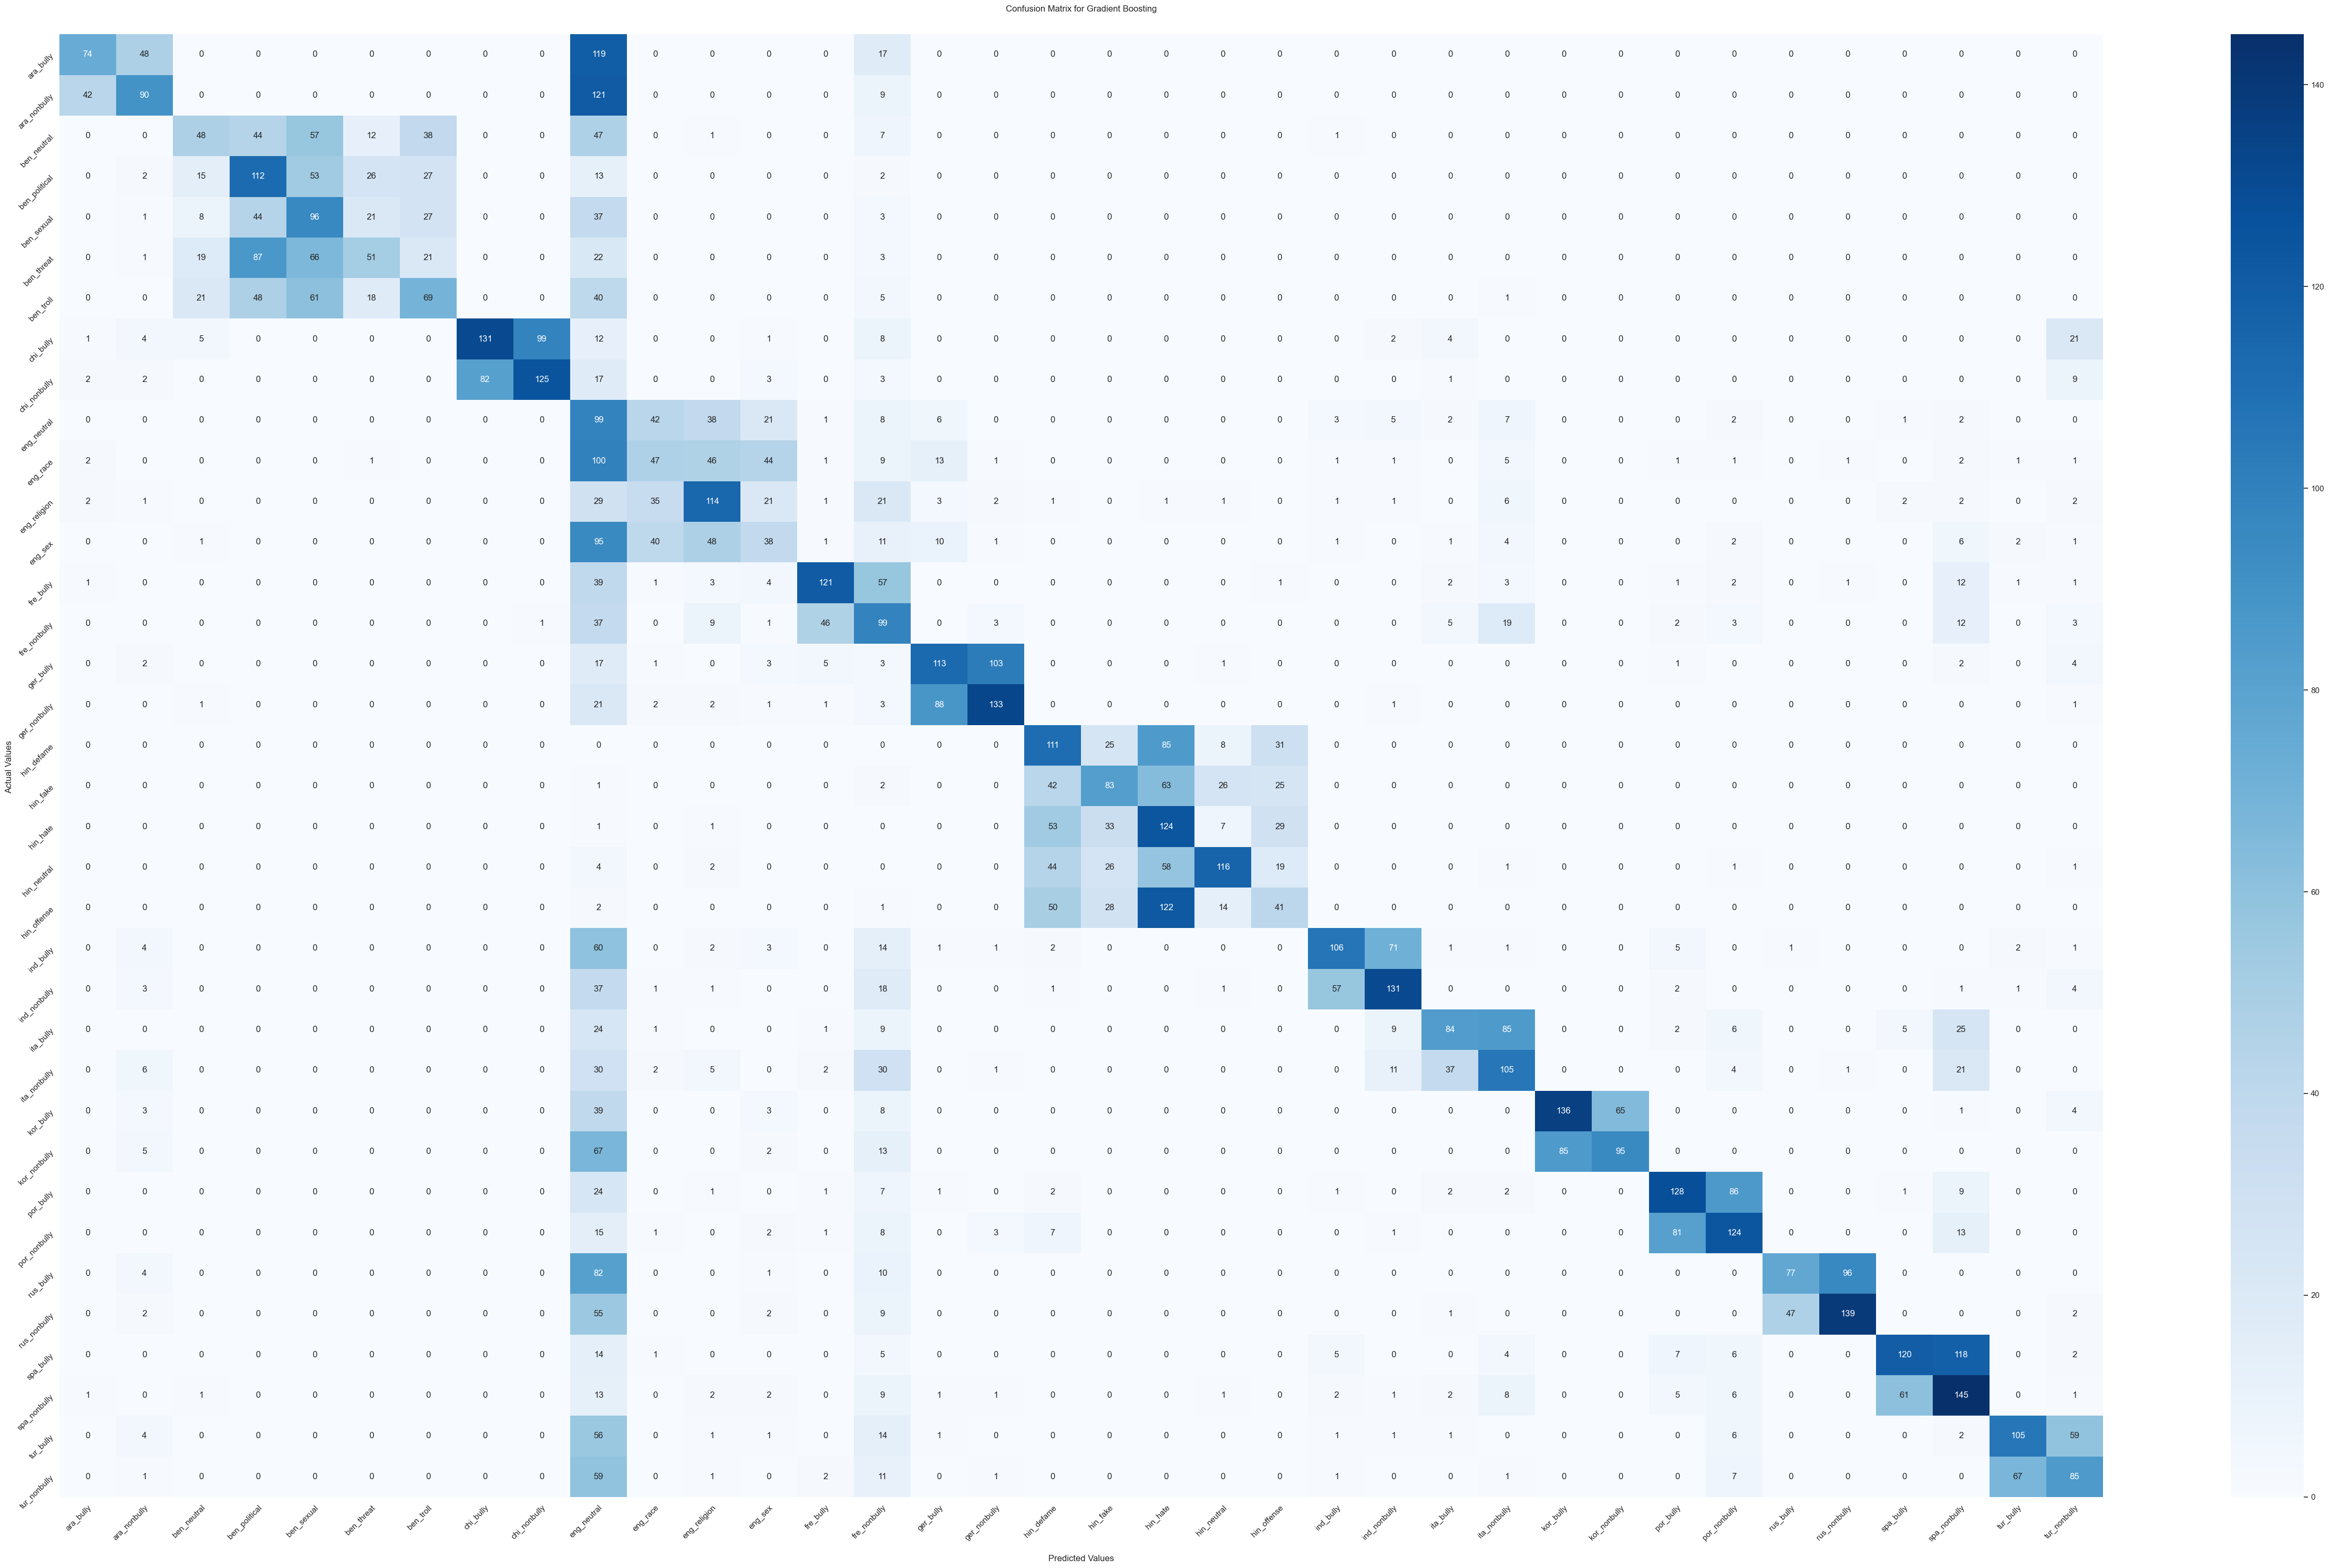

In [53]:
# from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_decoded,y_pred_gb_decoded)
#print(cf_matrix)

# Add labels, title, and ticks
fig = plt.figure(figsize=(50, 30))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

ax.set_title('Confusion Matrix for Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout() # Adjust layout to make room for labels
plt.show()

The Gradient Boosting Model performs most poor compared to others, let's exclude it from the final deployment

### 4.5 Convolutional Neural Networks

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import tensorflow as tf

# ===== 1. Tokenizer: exclusive for CNN =====
tokenizer = Tokenizer(num_words=10000)
cleaned_df['tokensCNN'] = cleaned_df['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
tokenizer.fit_on_texts(cleaned_df['tokensCNN'])
sequences = tokenizer.texts_to_sequences(cleaned_df['tokensCNN'])

# Padding
maxlen = 100
X_seq = pad_sequences(sequences, maxlen=maxlen)

# Perform oversampling
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_seq, y)

# ===== 3.  Train/Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [19]:
# After fitting tokenizer during training
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

with open("cnn_tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer.to_json())

In [83]:
# ===== 4. CNN 模型 =====
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
num_classes = len(le.classes_)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(128, 5, activation='relu'), #128: Number of filters (feature detectors). 5: Kernel size (window size over the sequence).
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(num_classes, activation='softmax') 
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [85]:
# ===== 5. 训练 =====
model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2  # 从训练集中再分出一部分做验证
)

print(model.summary())

Epoch 1/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.3724 - loss: 1.8681 - val_accuracy: 0.6113 - val_loss: 0.8436
Epoch 2/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.6392 - loss: 0.8313 - val_accuracy: 0.6703 - val_loss: 0.7374
Epoch 3/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.7266 - loss: 0.6571 - val_accuracy: 0.7027 - val_loss: 0.7253
Epoch 4/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.7726 - loss: 0.5646 - val_accuracy: 0.7137 - val_loss: 0.7396
Epoch 5/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8098 - loss: 0.4876 - val_accuracy: 0.7192 - val_loss: 0.7736
Epoch 6/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8348 - loss: 0.4248 - val_accuracy: 0.7254 - val_loss: 0.8442
Epoch 7/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8547 - loss: 0.3758 - val_accuracy: 0.7302 - val_loss: 0.8993
Epoch 8/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8705 - loss: 0.3374 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 50)        │     6,944,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 96, 128)        │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,962,274 (79.96 MB)

 Trainable params: 6,987,424 (26.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,974,850 (53.31 MB)

None


**🧠 CNN Text Classification Model — Architecture Summary**

This model processes sequences of word indices for multi-class text classification. Below is a layer-by-layer breakdown including output shapes, number of neurons, and trainable parameters.

📊 Layer Details

| Layer (Type)                        | Output Shape       | Neurons / Units         | Parameters |
|------------------------------------|--------------------|--------------------------|------------|
| **Embedding**                      | `(None, 100, 50)`  | — (outputs word vectors) | 6,944,700  |
| **Conv1D (128 filters, kernel=5)** | `(None, 96, 128)`  | 128 filters × 96 steps   | 32,128     |
| **GlobalMaxPooling1D**            | `(None, 128)`      | 128                      | 0          |
| **Dense (ReLU)**                   | `(None, 64)`       | 64                       | 8,256      |
| **Dropout (rate=0.5)**             | `(None, 64)`       | — (regularization only)  | 0          |
| **Dense (Softmax)**                | `(None, 36)`       | 36 (number of classes)   | 2,340      |

🧩 Notes

- **Input**: Sequence of 100 tokens, each mapped to a 50-dimensional vector.
- **Conv1D**: Extracts local n-gram features using 128 filters.
- **GlobalMaxPooling**: Captures the most salient feature per filter.
- **Dense Layers**: Learn higher-level representations and output class probabilities.
- **Dropout**: Prevents overfitting by randomly disabling 50% of neurons during training.

📈 Total Trainable Parameters:  
**~7 million**, dominated by the Embedding layer.

In [91]:
# ===== 6. 测试集评估 =====
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

# ===== 7. 分类报告 =====
y_pred_probs = model.predict(X_test)

y_pred_cnn = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred_cnn, digits=4, target_names=le.classes_))

print("Accuracy score for CNN : %.2f" % accuracy_score(y_test, y_pred_cnn))
print("Precision score for CNN : %.2f" % precision_score(y_test, y_pred_cnn, average='macro'))
print("Recall score for CNN : %.2f" % recall_score(y_test, y_pred_cnn, average='macro'))

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7481 - loss: 1.1078
Test Loss: 1.1078, Test Accuracy: 0.7481
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
               precision    recall  f1-score   support

    ara_bully     0.5758    0.8872    0.6983       257
 ara_nonbully     0.8591    0.7326    0.7908       258
  ben_neutral     0.6615    0.6589    0.6602       258
ben_political     0.8834    0.7636    0.8191       258
   ben_sexual     0.7172    0.6809    0.6986       257
   ben_threat     0.8130    0.8256    0.8192       258
    ben_troll     0.5719    0.6163    0.5933       258
    chi_bully     0.7720    0.7481    0.7598       258
 chi_nonbully     0.7538    0.7743    0.7639       257
  eng_neutral     0.8778    0.9222    0.8994       257
     eng_race     0.9773    1.0000    0.9885       258
 eng_religion     0.9385    0.9457    0.9421       258
      eng_sex     0.9922    0.9844    0.9883       257
    fre_bully     0.8157    0.8093    0.8125       257
 fre_nonbully    

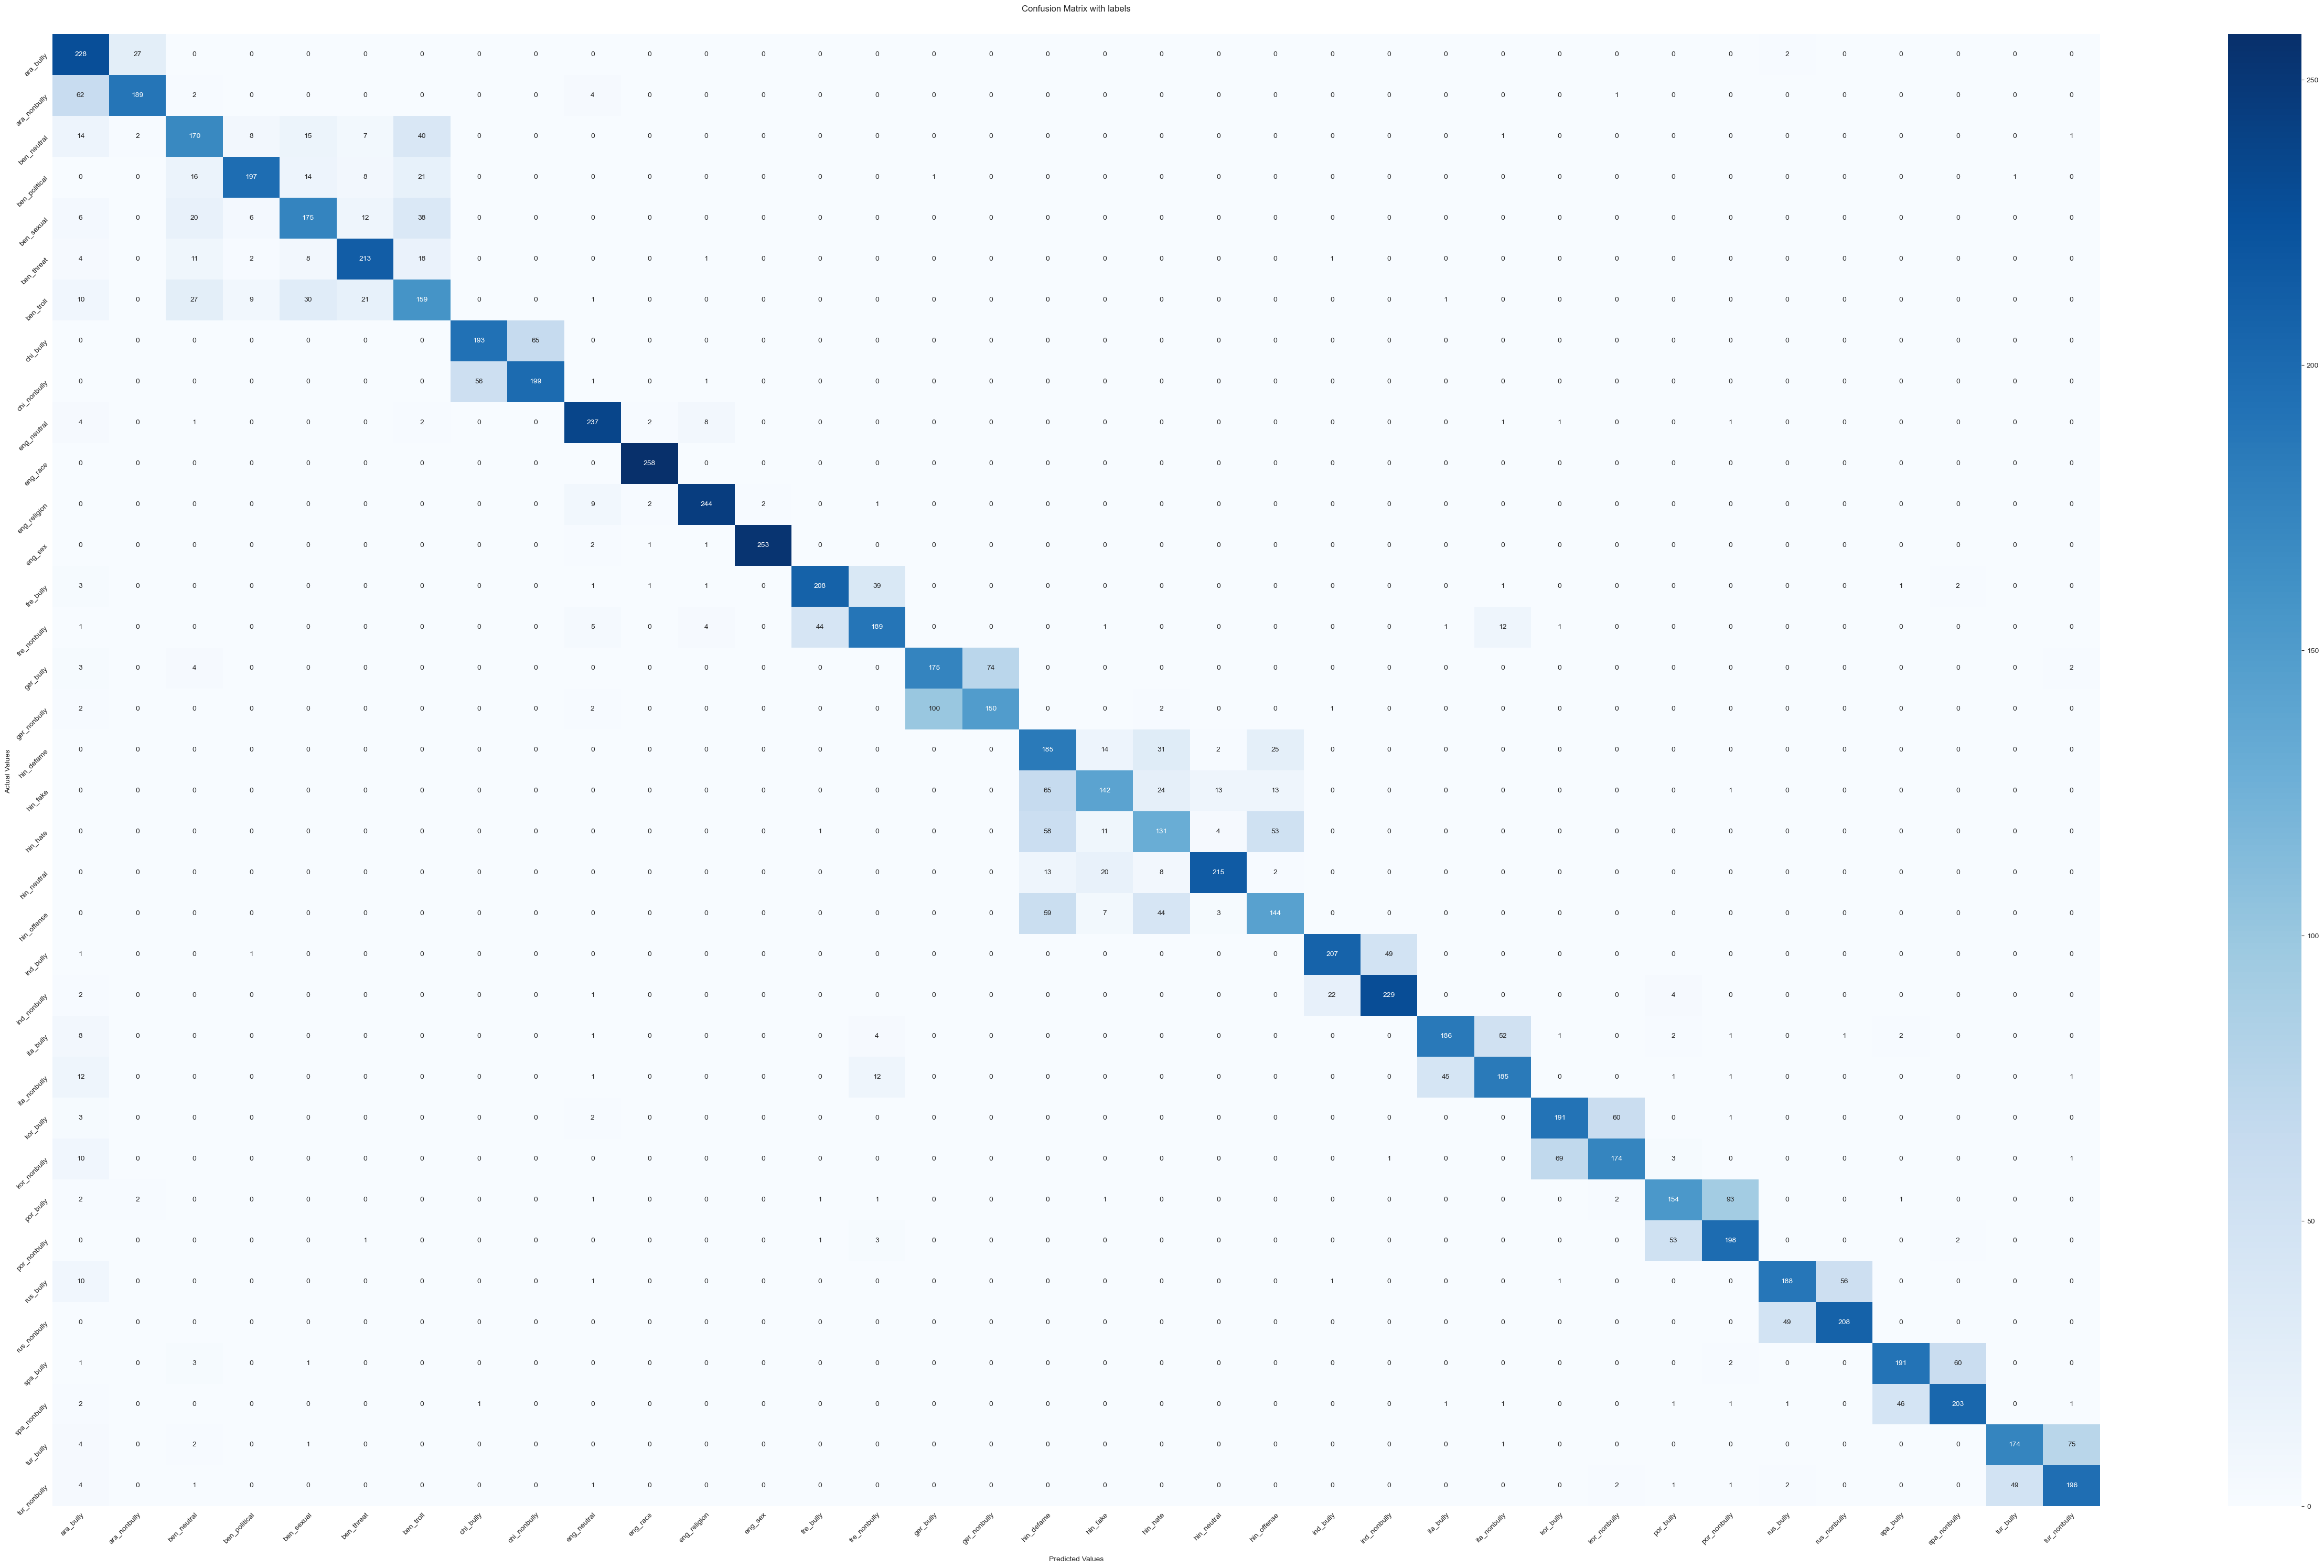

In [95]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred_cnn)
#print(cf_matrix)

# Add labels, title, and ticks
fig = plt.figure(figsize=(50, 30))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

ax.set_title('Confusion Matrix for CNN\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout() # Adjust layout to make room for labels
plt.show()

In [92]:
filename = "cnn_text_classifier.h5"
model.save(filename)
print(f"Model saved successfully to {filename}")


Model saved successfully to cnn_text_classifier.h5


### 4.6 Conclusion

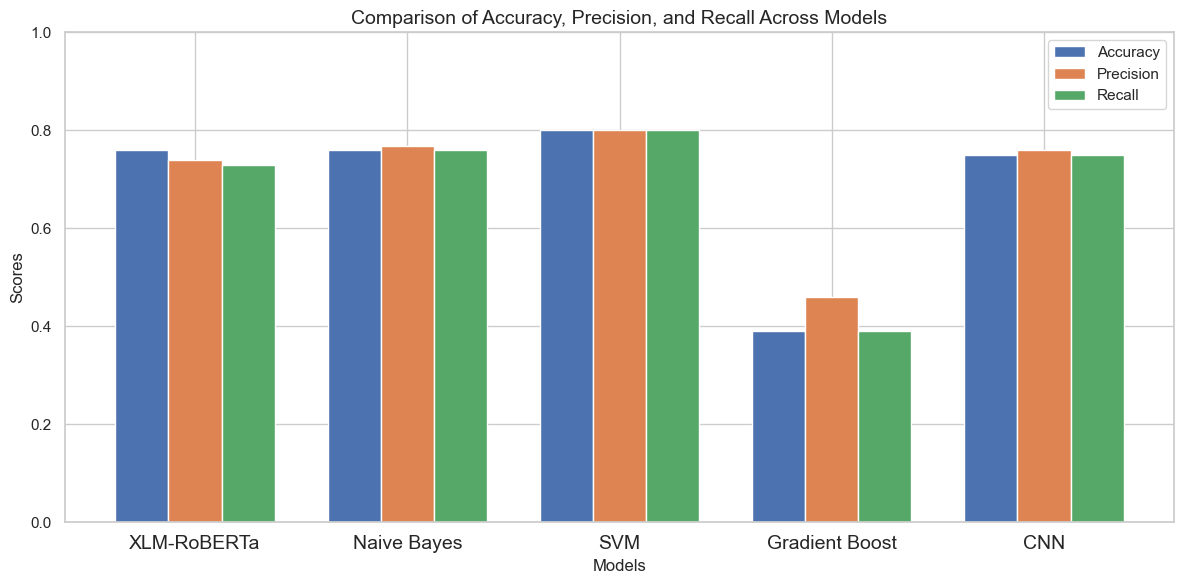

In [36]:
# Set seaborn style
sns.set_theme(style="whitegrid")

# Define model names and corresponding scores
models = ['XLM-RoBERTa', 'Naive Bayes', 'SVM', 'Gradient Boost', 'CNN']
accuracy = [0.76, 0.76, 0.8, 0.39, 0.75]
precision = [0.74, 0.7683, 0.8, 0.46, 0.76]
recall = [0.73, 0.7602, 0.8, 0.39, 0.75]

# Set up bar width and positions
bar_width = 0.25
x = np.arange(len(models))

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x, precision, width=bar_width, label='Precision')
plt.bar(x + bar_width, recall, width=bar_width, label='Recall')

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Comparison of Accuracy, Precision, and Recall Across Models', fontsize=14)
plt.xticks(x, models,fontsize=14)
plt.ylim(0, 1) #val between 0 and 1
plt.legend()

# Save the plot
plt.tight_layout()
#plt.savefig('model_scores_grouped_barplot.png')
plt.show()

## 5.0 Prototype Deployment

This is just a driver program. For the finalised code. Refer `main_st.py`

In [9]:
# --- Text Processing and Tokenization Imports ---
import nltk
import re
import numpy as np
import joblib
from langdetect import detect
import dill
from nltk.corpus import stopwords
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
import jieba

# Konlpy can be tricky on some systems, so we handle its import gracefully
try:
    from konlpy.tag import Okt, Mecab
except ImportError:
    print("Warning: konlpy not found. Korean tokenization will not be available.")
    Okt, Mecab = None, None

# --- ML/DL Model Imports ---
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.exceptions import NotFittedError 

# ==============================================================================
# SETUP: ONE-TIME DOWNLOADS AND INITIALIZATIONS
# This section replicates the setup from your notebook.
# ==============================================================================

print("--- Initializing Tokenization Resources ---")
try:
    # 📦 Download required NLTK resources
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)

    # Get English stopwords
    eng_stop_words = set(stopwords.words('english'))
    # Load Bengali stopwords from NLTK
    bengali_stopwords = set(stopwords.words('bengali'))

    # 🛑 Define Hindi stopwords manually
    hindi_stopwords = set([
        "और", "के", "है", "यह", "था", "जो", "पर", "को",
        "में", "से", "भी", "थे", "तक", "लेकिन"
    ])

    # 🔤 Set up Hindi text normalizer
    factory = IndicNormalizerFactory()
    normalizer = factory.get_normalizer("hi")

    # 🇰🇷 Set up Korean tokenizer (Mecab preferred, Okt as fallback)
    mecab = None
    if Mecab:
        try:
            mecab = Mecab()
            print("Using Mecab for Korean tokenization.")
        except:
            mecab = Okt()
            print("Mecab not found. Falling back to Okt for Korean tokenization.")

    print("--- Initialization Complete ---\n")

except Exception as e:
    print(f"An error occurred during initialization: {e}")
    print("Please ensure you have installed all required libraries (nltk, indic-nlp-library, jieba, konlpy, etc.).")
    # exit()


# ==============================================================================
# ALL TOKENIZATION FUNCTIONS FROM YOUR NOTEBOOK
# ==============================================================================

def tokenize_eng(text):
    tokens = nltk.word_tokenize(text)
    return [word for word in tokens if word not in eng_stop_words]

def tokenize_hin(text):
    text = normalizer.normalize(text)
    tokens = list(indic_tokenize.trivial_tokenize(text, lang='hi'))
    return [t for t in tokens if t not in hindi_stopwords]

def tokenize_ben(text):
    tokens = list(indic_tokenize.trivial_tokenize(text, lang='bn'))
    return [t for t in tokens if t not in bengali_stopwords]

def tokenize_ara(text):
    return text.split()

def tokenize_ger(text):
    return nltk.word_tokenize(text, language='german')

def tokenize_rus(text):
    return nltk.word_tokenize(text, language='russian')

def tokenize_fre(text):
    return nltk.word_tokenize(text, language='french')

def tokenize_ita(text):
    return nltk.word_tokenize(text, language='italian')

def tokenize_spa(text):
    return nltk.word_tokenize(text, language='spanish')

def tokenize_kor(text):
    if mecab:
        return mecab.morphs(text)
    else:
        # Fallback if konlpy is not installed
        return text.split()

def tokenize_tur(text):
    return nltk.word_tokenize(text, language='turkish')

def tokenize_chi(text):
    return list(jieba.cut(text))

def tokenize_por(text):
    return nltk.word_tokenize(text, language='portuguese')

def tokenize_ind(text):
    return nltk.word_tokenize(text)

# ===== Mapping Dictionary =====
label_descriptions = {
    'ara_bully': 'Arabic Bully Speech',
    'ara_nonbully': 'Arabic Non-Bully Speech',
    'ben_neutral': 'Bengali Neutral Speech',
    'ben_political': 'Bengali Political Speech',
    'ben_sexual': 'Bengali Sexual Speech',
    'ben_threat': 'Bengali Threat Speech',
    'ben_troll': 'Bengali Troll Speech',
    'chi_bully': 'Chinese Bully Speech',
    'chi_nonbully': 'Chinese Non-Bully Speech',
    'eng_neutral': 'English Neutral Speech',
    'eng_race': 'English Race-related Speech',
    'eng_religion': 'English Religion-related Speech',
    'eng_sex': 'English Sex-related Speech',
    'fre_bully': 'French Bully Speech',
    'fre_nonbully': 'French Non-Bully Speech',
    'ger_bully': 'German Bully Speech',
    'ger_nonbully': 'German Non-Bully Speech',
    'hin_defame': 'Hindi Defamation Speech',
    'hin_fake': 'Hindi Fake News',
    'hin_hate': 'Hindi Hate Speech',
    'hin_neutral': 'Hindi Neutral Speech',
    'hin_offense': 'Hindi Offensive Speech',
    'ind_bully': 'Indonesian Bully Speech',
    'ind_nonbully': 'Indonesian Non-Bully Speech',
    'ita_bully': 'Italian Bully Speech',
    'ita_nonbully': 'Italian Non-Bully Speech',
    'kor_bully': 'Korean Bully Speech',
    'kor_nonbully': 'Korean Non-Bully Speech',
    'por_bully': 'Portuguese Bully Speech',
    'por_nonbully': 'Portuguese Non-Bully Speech',
    'rus_bully': 'Russian Bully Speech',
    'rus_nonbully': 'Russian Non-Bully Speech',
    'spa_bully': 'Spanish Bully Speech',
    'spa_nonbully': 'Spanish Non-Bully Speech',
    'tur_bully': 'Turkish Bully Speech',
    'tur_nonbully': 'Turkish Non-Bully Speech'
}

lang_descriptions = {
    'ara': 'Arabic',
    'ben': 'Bengali',
    'chi': 'Chinese',
    'eng': 'English',
    'fre': 'French',
    'ger': 'German',
    'hin': 'Hindi',
    'ind': 'Indonesian',
    'ita': 'Italian',
    'kor': 'Korean',
    'por': 'Portuguese',
    'rus': 'Russian',
    'spa': 'Spanish',
    'tur': 'Turkish'
}

tokenizers = {
    'eng': tokenize_eng, 'hin': tokenize_hin, 'ben': tokenize_ben,
    'ara': tokenize_ara, 'ger': tokenize_ger, 'rus': tokenize_rus,
    'fre': tokenize_fre, 'ita': tokenize_ita, 'spa': tokenize_spa,
    'kor': tokenize_kor, 'tur': tokenize_tur, 'chi': tokenize_chi,
    'por': tokenize_por, 'ind': tokenize_ind
}

langdetect_to_tokenizer = {
    'en': 'eng', 'fr': 'fre', 'hi': 'hin', 'tr': 'tur', 'bn': 'ben',
    'ko': 'kor', 'zh': 'chi', 'zh-cn': 'chi', 'it': 'ita', 'es': 'spa',
    'id': 'ind', 'de': 'ger', 'pt': 'por', 'ru': 'rus', 'ar': 'ara'
}

# Define supported tokenizer codes
SUPPORTED_LANGUAGES = set(langdetect_to_tokenizer.values())

# ==============================================================================
# PREPROCESSING AND PREDICTION
# ==============================================================================
def passthrough_preprocessor(x):
    return x
def identity_tokenizer(text):
    return text

def preprocess_text(text):
    """Basic cleaning before language-specific tokenization."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = text.replace("“", "").replace("”", "")
    text = re.sub(r"[^\w\s\u4e00-\u9fff]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# --- Load Models and Preprocessing Objects ---
try:
    print("--- Loading Models and Vectorizers ---")
    svm_model = joblib.load('svm_finetuned_model.joblib')
    nb_model = joblib.load('nb_finetuned_model.joblib')
    
    with open('tfidf.dill', 'rb') as f:
        tfidf_vectorizer = dill.load(f)
        
    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = joblib.load("label_encoder.pkl")
        
    cnn_model = keras.models.load_model('cnn_text_classifier.h5')
    xlm_roberta_tokenizer = AutoTokenizer.from_pretrained('./xlm-roberta-large-model')
    xlm_roberta_model = AutoModelForSequenceClassification.from_pretrained('./xlm-roberta-large-model')
    print("--- Loading Complete ---\n")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Make sure all model and tokenizer files are in the correct directory.")
    # exit()
except NotFittedError:
    print("\n[Error] The loaded TF-IDF vectorizer has not been fitted.")
    print("Please run the script to fit and save your vectorizer on your training data first.\n")
    #exit()

# --- Prediction Functions ---

def predict_svm_nb_cnn(model, text_input, vectorizer, encoder, is_cnn=False):
    """
    Makes a prediction for SVM, NB, or CNN models.
    Takes a pre-tokenized, space-joined string.
    """
    text_vectorized = vectorizer.transform([text_input])
    if is_cnn:
        probabilities = model.predict(text_vectorized.toarray(), verbose=0)[0]
        confidence = np.max(probabilities)
        predicted_class_idx = np.argmax(probabilities)
        label = encoder.classes_[predicted_class_idx]
        return label, confidence
    else:
        # For SVM and Naive Bayes
        try:
            # Get probabilities for each class
            probabilities = model.predict_proba(text_vectorized)[0]
            confidence = np.max(probabilities)
            # Get the index of the highest probability to find the class
            predicted_class_idx = np.argmax(probabilities)
            label = encoder.classes_[predicted_class_idx]
            return label, confidence
        except AttributeError:
            # This happens if SVM was trained with probability=False
            print("Warning: .predict_proba() not available for the SVM model. Confidence score will be N/A.")
            print("         To fix this, retrain your SVM with the parameter `probability=True`.")
            label = model.predict(text_vectorized)[0]
            label = encoder.classes_[label]
            return label, None # Return None for confidence

def predict_xlm_roberta(model, tokenizer, raw_text, encoder):
    """
    Makes a prediction using the XLM-RoBERTa model.
    Takes a raw (but cleaned) sentence.
    """
    inputs = tokenizer(raw_text, 
                       return_tensors="pt", 
                       padding='max_length', 
                       truncation=True, 
                       max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)[0] # Get probabilities for the first (and only) input

    
    # Get the confidence and the predicted class index
    confidence = torch.max(probabilities).item()
    predicted_class_idx = torch.argmax(probabilities).item()
    
    label = encoder.classes_[predicted_class_idx]
    
    return label, confidence
# ==============================================================================
# FINAL PREPS...
# ==============================================================================
# --- Display the final results with confidence scores and descriptions ---
def format_prediction(label, confidence):
    """Returns formatted string with description and confidence."""
    description = label_descriptions.get(label, label)
    conf_str = f"({confidence*100:.2f}%)" if confidence is not None else "(Confidence N/A)"
    return f"{description} {conf_str}"

# --- Warn if detected language mismatches predicted label language ---
def warn_if_mismatch(model_name, predicted_lang, detected_lang_code):
    if predicted_lang != detected_lang_code:
        detected_lang_name = lang_descriptions.get(f"{detected_lang_code}", detected_lang_code).split()[0]
        predicted_lang_name = lang_descriptions.get(f"{predicted_lang}", predicted_lang).split()[0]
        print(f"⚠️ Warning: Detected language is {detected_lang_name}, but {model_name} predicted {predicted_lang_name}!")
        
def extract_language_code(label: str) -> str:
    """Extracts the first three-letter language code from a label string."""
    return label.split('_')[0] if label else "Unknown"
# ==============================================================================
# MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == "__main__":

    # Get user input
    user_sentence = input("Please enter a sentence for classification:\n> ")

    # Step 1: Clean the sentence
    cleaned_sentence = preprocess_text(user_sentence)
    print(f"\nStep 1: Text cleaned. Result: '{cleaned_sentence}'")

    # Step 2: Detect language and map to tokenizer
    try:
        detected_lang = detect(cleaned_sentence)
        detected_lang_code = langdetect_to_tokenizer.get(detected_lang, 'ara')
        if detected_lang_code not in SUPPORTED_LANGUAGES:
            print(f"Detected language '{detected_lang}' is unsupported. Defaulting to 'ara'.")
            detected_lang_code = 'ara'
        else:
            print(f"Step 2: Language detected as '{detected_lang}', using tokenizer '{detected_lang_code}'")
    except Exception as e:
        detected_lang_code = 'ara'
        print(f"Step 2: Language detection failed ({e}). Defaulting to tokenizer 'ara'.")

    # Step 3: Tokenize
    tokenizer_func = tokenizers.get(detected_lang_code, tokenizers['ara'])
    tokens = tokenizer_func(cleaned_sentence)
    tokenized_for_sklearn = " ".join(tokens)
    print(f"Step 3: Tokenization complete. Tokens: {tokens}")

    # Step 4: Predictions
    print("\nGetting predictions...\n")

    # For SVM, NB, and CNN, use the tokenized and space-joined string
    svm_prediction, svm_confidence = predict_svm_nb_cnn(
        svm_model, tokenized_for_sklearn, tfidf_vectorizer, label_encoder
    )

    nb_prediction, nb_confidence = predict_svm_nb_cnn(
        nb_model, tokenized_for_sklearn, tfidf_vectorizer, label_encoder
    )

    cnn_prediction, cnn_confidence = predict_svm_nb_cnn(
        cnn_model, tokenized_for_sklearn, tfidf_vectorizer, label_encoder, is_cnn=True
    )

    xlm_prediction, xlm_confidence = predict_xlm_roberta(
        xlm_roberta_model, xlm_roberta_tokenizer, cleaned_sentence, label_encoder
    )
    
    # Extract predicted language codes
    svm_lang = extract_language_code(svm_prediction)
    nb_lang = extract_language_code(nb_prediction)
    cnn_lang = extract_language_code(cnn_prediction)
    xlm_lang = extract_language_code(xlm_prediction)
    
     # --- Display the final results with confidence scores ---
    # Format the confidence score as a percentage, or show 'N/A' if it's not available
    svm_conf_str = f"({svm_confidence*100:.2f}%)" if svm_confidence is not None else "(Confidence N/A)"
    nb_conf_str = f"({nb_confidence*100:.2f}%)"
    cnn_conf_str = f"({cnn_confidence*100:.2f}%)"
    xlm_conf_str = f"({xlm_confidence*100:.2f}%)"

    # Display the final results
    print("\n--- Model Predictions ---")
    print(f"SVM Model Prediction:         {format_prediction(svm_prediction, svm_confidence)}")
    print(f"Naive Bayes Model Prediction: {format_prediction(nb_prediction, nb_confidence)}")
    print(f"CNN Model Prediction:         {format_prediction(cnn_prediction, cnn_confidence)}")
    print(f"XLM-RoBERTa Model Prediction: {format_prediction(xlm_prediction, xlm_confidence)}")
    print("-------------------------")
    
    # Check each model
    warn_if_mismatch("SVM", svm_lang, detected_lang_code)
    warn_if_mismatch("Naive Bayes", nb_lang, detected_lang_code)
    warn_if_mismatch("CNN", cnn_lang, detected_lang_code)
    warn_if_mismatch("XLM-RoBERTa", xlm_lang, detected_lang_code)
    
    print("-------------------------")
    

--- Initializing Tokenization Resources ---
Mecab not found. Falling back to Okt for Korean tokenization.
--- Initialization Complete ---

--- Loading Models and Vectorizers ---
--- Loading Complete ---



KeyboardInterrupt: Interrupted by user